### Using larger windowsizes to plot mutation rate as function of distance to CDR

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df.head()

sample1    sample2  direct_pairwise_dist   chr
0  HG03098.1  HG03784.1              0.942968  chr6
1  HG03098.1  NA20752.2              0.974936  chr6
2  HG01978.2  NA19835.1              0.999883  chr6
3  HG00741.1  NA18522.1              0.999869  chr6
4  HG00408.1  HG01496.1              0.606856  chr6

In [3]:
def classify_shape(diff):
    if diff == -1:
        return "triangle"
    elif 0 <= diff <= 0.1:
        return "parallelogram"
    elif diff > 0.1:
        return "trapezoid"
    else:
        return np.nan

### SVs - 50kb windows 

In [4]:
def load_matching_SV_beds(chr_str, bed_folder, pairs_df, suffix):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 4,5, 6, 7, 8, 9,10,11,12,18]
    col_names = [
        "SV_contig",
        "SV_start",
        "SV_end",
        "par_counts",
        "par_rate",
        "trap_counts",
        "trap_rate",
        "tri_counts",
        "tri_rate",
        "CDR_contig",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_distance"
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):

        if not fname.endswith(suffix):
            continue

        base = fname.replace(suffix, "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )

        #if bed_df.shape[1] <= max(col_indices):
            #print("Unexpected column count:", bed_path, bed_df.shape[1])
            #continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)

In [5]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/SVs_induced_pairwise/50kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_SV_beds(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".CDR_dist.50kb.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
SV_50kb_df = pd.concat(all_chrom_dfs, ignore_index=True)

SV_50kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  HG03710#2#CM086879.1  121750812  121800812           0       0.0   
1  HG03710#2#CM086879.1  121800812  121850812           0       0.0   
2  HG03710#2#CM086879.1  121850812  121900812           0       0.0   
3  HG03710#2#CM086879.1  121900812  121950812           0       0.0   
4  HG03710#2#CM086879.1  121950812  122000812           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate            CDR_contig  \
0            0    0.00000        1019   0.02038  HG03710#2#CM086879.1   
1            0    0.00000        1020   0.02040  HG03710#2#CM086879.1   
2            0    0.00000       10528   0.21056  HG03710#2#CM086879.1   
3        10528    0.21056        3742   0.07484  HG03710#2#CM086879.1   
4            0    0.00000           1   0.00002  HG03710#2#CM086879.1   

   CDR_start    CDR_end CDR_status  CDR_distance    sample1    sample2   chr  \
0  123022959  123030439        CDR       1222148  HG04115.1  HG03710.2  chr1   
1  123022959  123030439        CDR       1172148  HG04115.1  HG03710.2  chr1   
2  123022959  123030439        CDR       1122148  HG04115.1  HG03710.2  chr1   
3  123022959  123030439        CDR       1072148  HG04115.1  HG03710.2  chr1   
4  123022959  123030439        CDR       1022148  HG04115.1  HG03710.2  chr1   

   both_pairs_CDR  
0            True  
1            True  
2            True  
3            True  
4            True

In [6]:
# add rate for all variants
SV_50kb_df["all_counts"] = (
    SV_50kb_df["par_counts"]
    + SV_50kb_df["trap_counts"]
    + SV_50kb_df["tri_counts"]
)

SV_50kb_df["all_rate"] = SV_50kb_df["all_counts"] / 50000

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
SV_50kb_df["CDR_distance"] = -SV_50kb_df["CDR_distance"]

SV_50kb_df.head()

SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  HG03710#2#CM086879.1  121750812  121800812           0       0.0   
1  HG03710#2#CM086879.1  121800812  121850812           0       0.0   
2  HG03710#2#CM086879.1  121850812  121900812           0       0.0   
3  HG03710#2#CM086879.1  121900812  121950812           0       0.0   
4  HG03710#2#CM086879.1  121950812  122000812           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate            CDR_contig  \
0            0    0.00000        1019   0.02038  HG03710#2#CM086879.1   
1            0    0.00000        1020   0.02040  HG03710#2#CM086879.1   
2            0    0.00000       10528   0.21056  HG03710#2#CM086879.1   
3        10528    0.21056        3742   0.07484  HG03710#2#CM086879.1   
4            0    0.00000           1   0.00002  HG03710#2#CM086879.1   

   CDR_start    CDR_end CDR_status  CDR_distance    sample1    sample2   chr  \
0  123022959  123030439        CDR      -1222148  HG04115.1  HG03710.2  chr1   
1  123022959  123030439        CDR      -1172148  HG04115.1  HG03710.2  chr1   
2  123022959  123030439        CDR      -1122148  HG04115.1  HG03710.2  chr1   
3  123022959  123030439        CDR      -1072148  HG04115.1  HG03710.2  chr1   
4  123022959  123030439        CDR      -1022148  HG04115.1  HG03710.2  chr1   

   both_pairs_CDR  all_counts  all_rate  
0            True        1019   0.02038  
1            True        1020   0.02040  
2            True       10528   0.21056  
3            True       14270   0.28540  
4            True           1   0.00002

#### Chrom-weighted average lines, for all SVs. 50kb windows

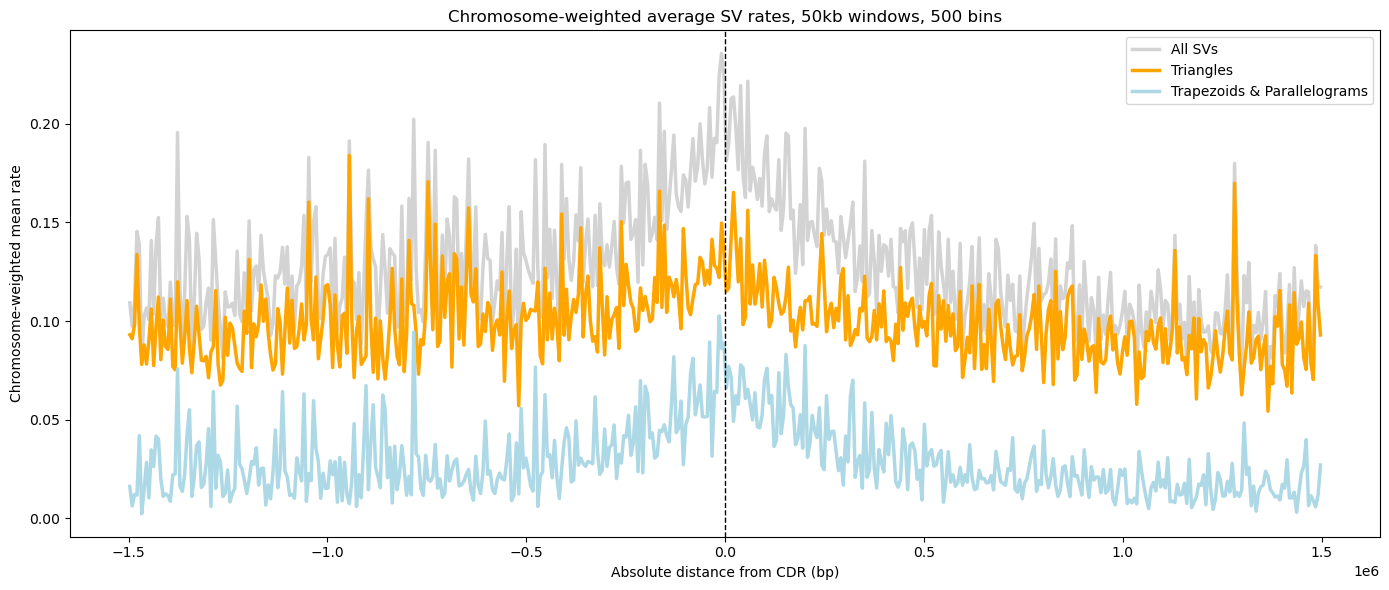

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = SV_50kb_df[SV_50kb_df["CDR_start"] != -1].copy()

# Combine trap and par rates
df["trap_par_rate"] = df["trap_rate"] + df["par_rate"]

# Bin distances
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Define rate columns and colors
rate_columns = ["all_rate", "tri_rate", "trap_par_rate"]
colors = ["lightgrey", "orange", "lightblue"]
labels = ["All SVs", "Triangles","Trapezoids & Parallelograms"]

# 4. Plot
plt.figure(figsize=(14,6))

for rate_col, color, label in zip(rate_columns, colors, labels):
    # Per-chromosome mean per bin
    chrom_bin_means = (
        df.groupby(["chr", "distance_bin"], as_index=False)
          .agg(mean_rate=(rate_col, "mean"))
    )
    
    # Chromosome-weighted genome average
    genome_avg = (
        chrom_bin_means.groupby("distance_bin", as_index=False)
                       .agg(mean_rate=("mean_rate", "mean"))
                       .sort_values("distance_bin")
    )
    
    plt.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color=color,
        linewidth=2.5,
        label=label
    )

# 5. Vertical line at CDR
plt.axvline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Absolute distance from CDR (bp)")
plt.ylabel("Chromosome-weighted mean rate")
plt.title("Chromosome-weighted average SV rates, 50kb windows, 500 bins")
plt.legend()
plt.tight_layout()
plt.show()

### SVs, 100kb windows 

In [7]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/SVs_induced_pairwise/100kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_SV_beds(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".CDR_dist.100kb.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
SV_100kb_df = pd.concat(all_chrom_dfs, ignore_index=True)

# add rate for all variants
SV_100kb_df["all_counts"] = (
    SV_100kb_df["par_counts"]
    + SV_100kb_df["trap_counts"]
    + SV_100kb_df["tri_counts"]
)

SV_100kb_df["all_rate"] = SV_100kb_df["all_counts"] / 100000

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
SV_100kb_df["CDR_distance"] = -SV_100kb_df["CDR_distance"]

SV_100kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  HG02071#2#JBHIGJ010000042.1  121968105  122068105           0       0.0   
1  HG02071#2#JBHIGJ010000042.1  122068105  122168105           0       0.0   
2  HG02071#2#JBHIGJ010000042.1  122168105  122268105           0       0.0   
3  HG02071#2#JBHIGJ010000042.1  122268105  122368105           0       0.0   
4  HG02071#2#JBHIGJ010000042.1  122368105  122468105           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate                   CDR_contig  \
0            0    0.00000       13578   0.13578  HG02071#2#JBHIGJ010000042.1   
1            1    0.00001        7900   0.07900  HG02071#2#JBHIGJ010000042.1   
2         1360    0.01360        5438   0.05438  HG02071#2#JBHIGJ010000042.1   
3            0    0.00000        8653   0.08653  HG02071#2#JBHIGJ010000042.1   
4            1    0.00001        5783   0.05783  HG02071#2#JBHIGJ010000042.1   

   CDR_start    CDR_end CDR_status  CDR_distance    sample1    sample2   chr  \
0  122760020  122848872        CDR       -691916  HG02071.2  NA18747.1  chr1   
1  122760020  122848872        CDR       -591916  HG02071.2  NA18747.1  chr1   
2  122760020  122848872        CDR       -491916  HG02071.2  NA18747.1  chr1   
3  122760020  122848872        CDR       -391916  HG02071.2  NA18747.1  chr1   
4  122760020  122848872        CDR       -291916  HG02071.2  NA18747.1  chr1   

   both_pairs_CDR  all_counts  all_rate  
0            True       13578   0.13578  
1            True        7901   0.07901  
2            True        6798   0.06798  
3            True        8653   0.08653  
4            True        5784   0.05784

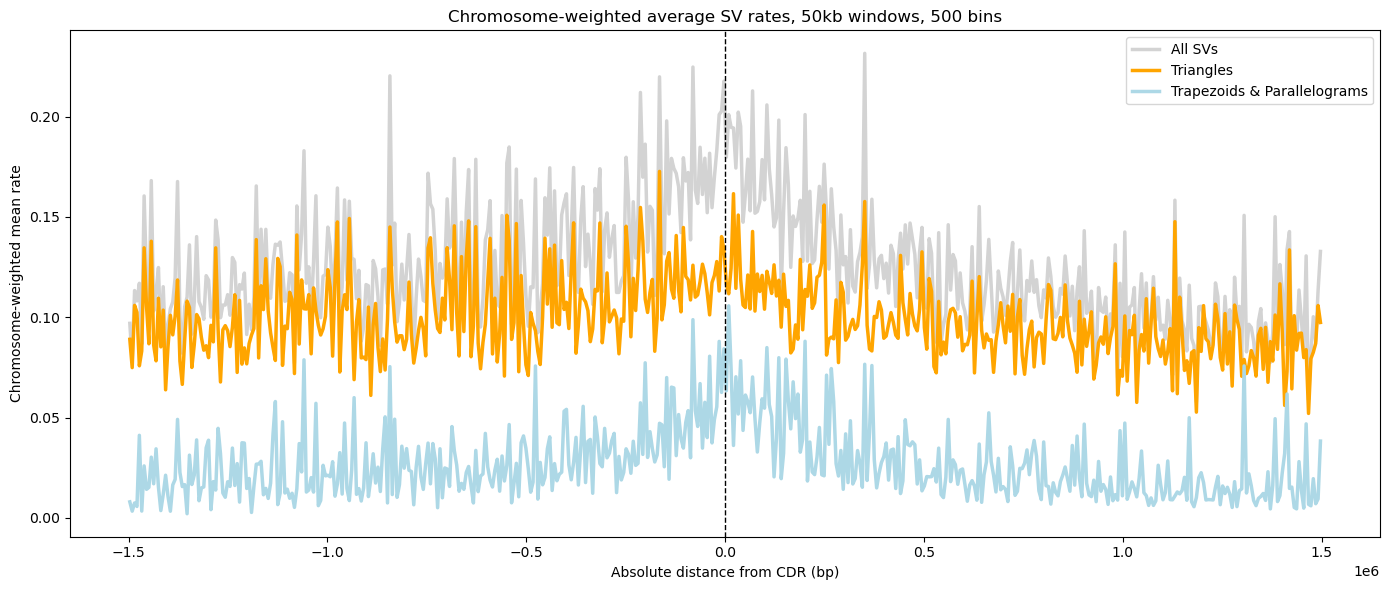

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = SV_100kb_df[SV_100kb_df["CDR_start"] != -1].copy()

# Combine trap and par rates
df["trap_par_rate"] = df["trap_rate"] + df["par_rate"]

# Bin distances
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Define rate columns and colors
rate_columns = ["all_rate", "tri_rate", "trap_par_rate"]
colors = ["lightgrey", "orange", "lightblue"]
labels = ["All SVs", "Triangles","Trapezoids & Parallelograms"]

# 4. Plot
plt.figure(figsize=(14,6))

for rate_col, color, label in zip(rate_columns, colors, labels):
    # Per-chromosome mean per bin
    chrom_bin_means = (
        df.groupby(["chr", "distance_bin"], as_index=False)
          .agg(mean_rate=(rate_col, "mean"))
    )
    
    # Chromosome-weighted genome average
    genome_avg = (
        chrom_bin_means.groupby("distance_bin", as_index=False)
                       .agg(mean_rate=("mean_rate", "mean"))
                       .sort_values("distance_bin")
    )
    
    plt.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color=color,
        linewidth=2.5,
        label=label
    )

# 5. Vertical line at CDR
plt.axvline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Absolute distance from CDR (bp)")
plt.ylabel("Chromosome-weighted mean rate")
plt.title("Chromosome-weighted average SV rates, 100kb windows, 500 bins")
plt.legend()
plt.tight_layout()
plt.show()

### SVs, 100kb windows, combining trapezoids and triangles and dropping parallelograms 

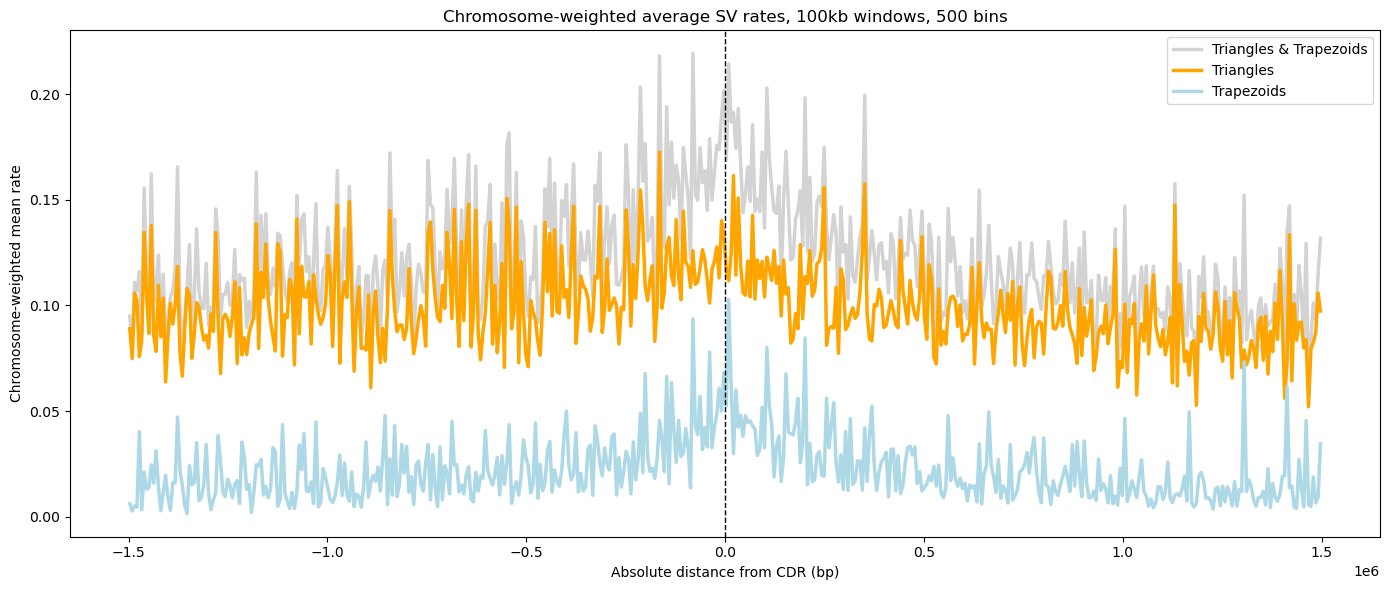

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# 2. Filter and assign bins
df = SV_100kb_df[SV_100kb_df["CDR_start"] != -1].copy()

# Combine trap and par rates
df["tri_trap_rate"] = df["trap_rate"] + df["tri_rate"]

# Bin distances
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# 3. Define rate columns and colors
rate_columns = ["tri_trap_rate", "tri_rate", "trap_rate"]
colors = ["lightgrey", "orange", "lightblue"]
labels = ["Triangles & Trapezoids", "Triangles","Trapezoids"]

# 4. Plot
plt.figure(figsize=(14,6))

for rate_col, color, label in zip(rate_columns, colors, labels):
    # Per-chromosome mean per bin
    chrom_bin_means = (
        df.groupby(["chr", "distance_bin"], as_index=False)
          .agg(mean_rate=(rate_col, "mean"))
    )
    
    # Chromosome-weighted genome average
    genome_avg = (
        chrom_bin_means.groupby("distance_bin", as_index=False)
                       .agg(mean_rate=("mean_rate", "mean"))
                       .sort_values("distance_bin")
    )
    
    plt.plot(
        genome_avg["distance_bin"],
        genome_avg["mean_rate"],
        color=color,
        linewidth=2.5,
        label=label
    )

# 5. Vertical line at CDR
plt.axvline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Absolute distance from CDR (bp)")
plt.ylabel("Chromosome-weighted mean rate")
plt.title("Chromosome-weighted average SV rates, 100kb windows, 500 bins")
plt.legend()
plt.tight_layout()
plt.show()

### Short indels, 10kb windows 

In [44]:
def load_matching_bed_aln(chr_str, bed_folder, pairs_df, suffix):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 4,5, 6, 7, 8, 9,10,11,12,18,19]
    col_names = [
        "SV_contig",
        "SV_start",
        "SV_end",
        "par_counts",
        "par_rate",
        "trap_counts",
        "trap_rate",
        "tri_counts",
        "tri_rate",
        "CDR_contig",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_distance",
        "aligned_bases"
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):
        if not fname.endswith(suffix):
            continue

        base = fname.replace(suffix, "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )
        #if bed_df.shape[1] <= max(col_indices):
            #print("Unexpected column count:", bed_path, bed_df.shape[1])
            #continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)

In [10]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/aligned_bases_per_bed/short_indels_pairwise_10kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_bed_aln(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".aligned_bases.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
short_indel_10kb_df = pd.concat(all_chrom_dfs, ignore_index=True)

short_indel_10kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  NA19909#2#CM094132.1  121895768  121905768           0       0.0   
1  NA19909#2#CM094132.1  121905768  121915768           0       0.0   
2  NA19909#2#CM094132.1  121915768  121925768           0       0.0   
3  NA19909#2#CM094132.1  121925768  121935768           0       0.0   
4  NA19909#2#CM094132.1  121935768  121945768           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate            CDR_contig  \
0            0        0.0           0       0.0  NA19909#2#CM094132.1   
1            0        0.0           0       0.0  NA19909#2#CM094132.1   
2            0        0.0           0       0.0  NA19909#2#CM094132.1   
3            0        0.0           0       0.0  NA19909#2#CM094132.1   
4            0        0.0           0       0.0  NA19909#2#CM094132.1   

   CDR_start    CDR_end CDR_status  CDR_distance  aligned_bases    sample1  \
0  124208369  124227486        CDR       2302602           7625  HG01784.1   
1  124208369  124227486        CDR       2292602          10000  HG01784.1   
2  124208369  124227486        CDR       2282602           9901  HG01784.1   
3  124208369  124227486        CDR       2272602           7382  HG01784.1   
4  124208369  124227486        CDR       2262602           6600  HG01784.1   

     sample2   chr  both_pairs_CDR  
0  NA19909.2  chr1            True  
1  NA19909.2  chr1            True  
2  NA19909.2  chr1            True  
3  NA19909.2  chr1            True  
4  NA19909.2  chr1            True

In [11]:
# add rate for all variants
short_indel_10kb_df["all_counts"] = (
    short_indel_10kb_df["par_counts"]
    + short_indel_10kb_df["trap_counts"]
    + short_indel_10kb_df["tri_counts"]
)

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
short_indel_10kb_df["CDR_distance"] = -short_indel_10kb_df["CDR_distance"]

short_indel_10kb_df["tri_rate_aln_bases"] = short_indel_10kb_df["tri_counts"] / short_indel_10kb_df["aligned_bases"]
short_indel_10kb_df["par_rate_aln_bases"] = short_indel_10kb_df["par_counts"] / short_indel_10kb_df["aligned_bases"]
short_indel_10kb_df["trap_rate_aln_bases"] = short_indel_10kb_df["trap_counts"] / short_indel_10kb_df["aligned_bases"]

short_indel_10kb_df["all_rate_aln_bases"] = short_indel_10kb_df["all_counts"] / short_indel_10kb_df["aligned_bases"]
short_indel_10kb_df.head()

SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  NA19909#2#CM094132.1  121895768  121905768           0       0.0   
1  NA19909#2#CM094132.1  121905768  121915768           0       0.0   
2  NA19909#2#CM094132.1  121915768  121925768           0       0.0   
3  NA19909#2#CM094132.1  121925768  121935768           0       0.0   
4  NA19909#2#CM094132.1  121935768  121945768           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate            CDR_contig  ...  \
0            0        0.0           0       0.0  NA19909#2#CM094132.1  ...   
1            0        0.0           0       0.0  NA19909#2#CM094132.1  ...   
2            0        0.0           0       0.0  NA19909#2#CM094132.1  ...   
3            0        0.0           0       0.0  NA19909#2#CM094132.1  ...   
4            0        0.0           0       0.0  NA19909#2#CM094132.1  ...   

   aligned_bases    sample1    sample2   chr  both_pairs_CDR all_counts  \
0           7625  HG01784.1  NA19909.2  chr1            True          0   
1          10000  HG01784.1  NA19909.2  chr1            True          0   
2           9901  HG01784.1  NA19909.2  chr1            True          0   
3           7382  HG01784.1  NA19909.2  chr1            True          0   
4           6600  HG01784.1  NA19909.2  chr1            True          0   

  tri_rate_aln_bases par_rate_aln_bases  trap_rate_aln_bases  \
0                0.0                0.0                  0.0   
1                0.0                0.0                  0.0   
2                0.0                0.0                  0.0   
3                0.0                0.0                  0.0   
4                0.0                0.0                  0.0   

   all_rate_aln_bases  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  

[5 rows x 24 columns]

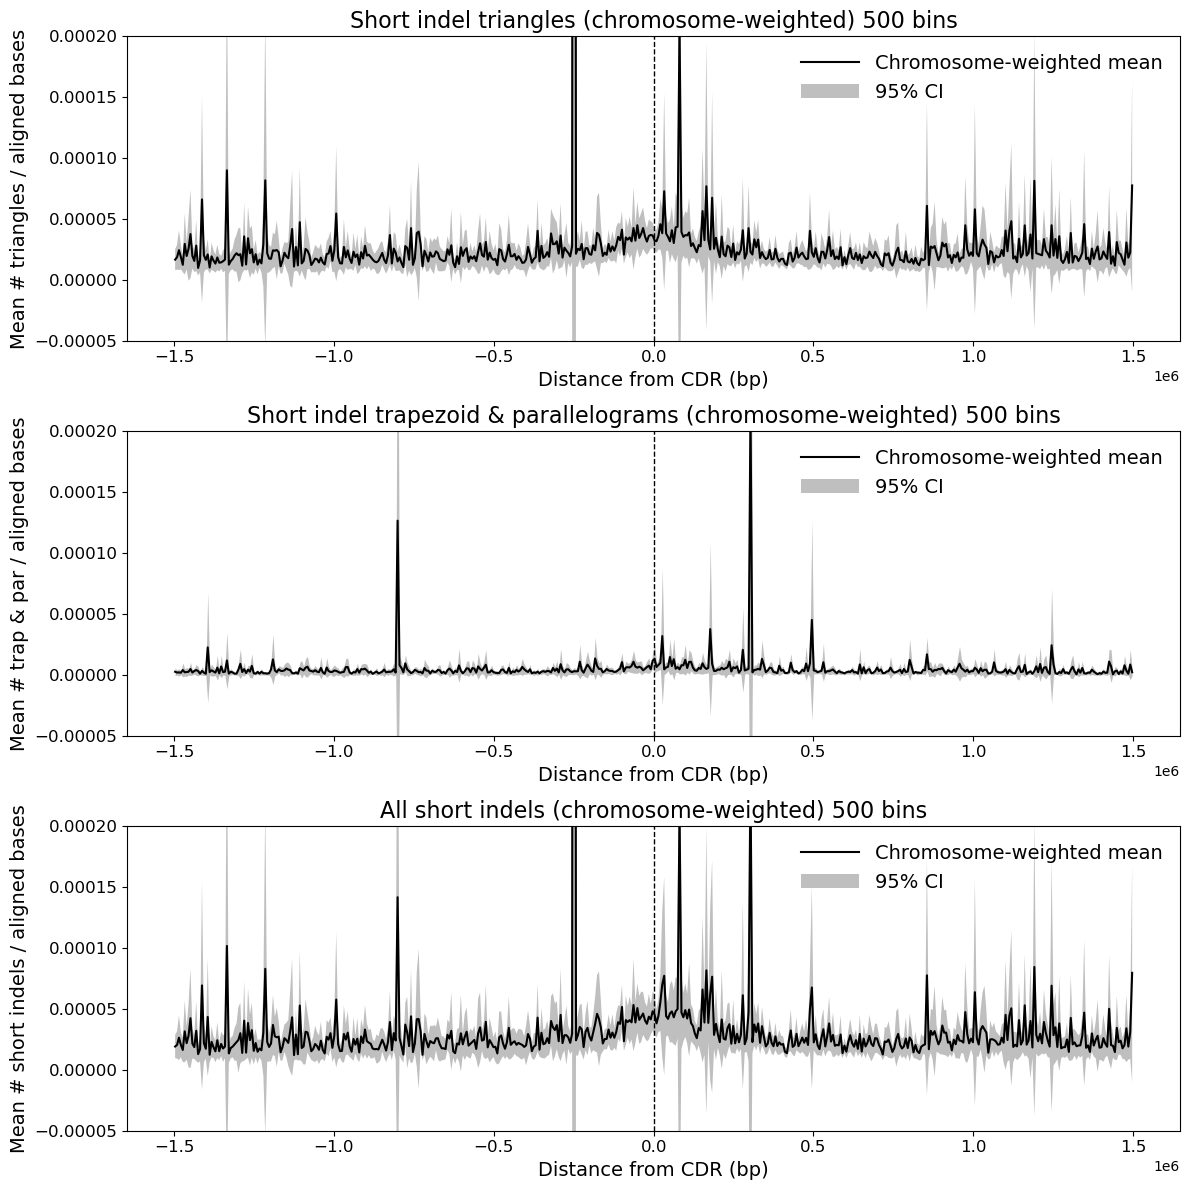

In [ ]:
### Averaging within chrom, then each window plotting the average across chroms 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])


# ----------------------------
# 2. Filter and prepare dataframe
# ----------------------------
df = short_indel_10kb_df[short_indel_10kb_df["CDR_start"] != -1].copy()

# ----------------------------
# Drop chromosomes with < 20 sample pairs
# ----------------------------

df["sample_pair"] = (
    df[["sample1", "sample2"]]
    .astype(str)
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

pair_counts = (
    df[["chr", "sample_pair"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
)

valid_chroms = pair_counts[pair_counts >= 20].index

df = df[df["chr"].isin(valid_chroms)].copy()


df["trap_par_rate"] = (
    df["par_rate_aln_bases"] + df["trap_rate_aln_bases"]
)

rate_columns = [
    "tri_rate_aln_bases",
    "trap_par_rate",
    "all_rate_aln_bases"
]

# Clean invalid values
df[rate_columns] = df[rate_columns].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Plot labels
# ----------------------------
plot_titles = [
    "Short indel triangles (chromosome-weighted) 500 bins",
    "Short indel trapezoid & parallelograms (chromosome-weighted) 500 bins",
    "All short indels (chromosome-weighted) 500 bins"
]
y_labels = [
    "Mean # triangles / aligned bases",
    "Mean # trap & par / aligned bases",
    "Mean # short indels / aligned bases"
]

# ----------------------------
# 3. Create subplots
# ----------------------------
fig, axes = plt.subplots(len(rate_columns), 1, figsize=(12, 12))

for ax, rate_col, title, y_label in zip(
    axes, rate_columns, plot_titles, y_labels
):

    # ------------------------------------------------
    # Step 1: mean per chromosome per bin
    # ------------------------------------------------
    chrom_bin_means = (
        df.groupby(["distance_bin", "chr"])
          .agg(chrom_mean=(rate_col, "mean"))
          .reset_index()
    )

    # ------------------------------------------------
    # Step 2: chromosome-weighted genome average
    # ------------------------------------------------
    agg = (
        chrom_bin_means
        .groupby("distance_bin")
        .agg(
            mean_rate=("chrom_mean", "mean"),
            std_rate=("chrom_mean", "std"),
            n_chroms=("chrom_mean", "count")
        )
        .reset_index()
        .sort_values("distance_bin")
    )

    # ------------------------------------------------
    # Step 3: t-distribution CI (chromosomes = n)
    # ------------------------------------------------
    agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
    agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
    agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
    agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

    # ------------------------------------------------
    # Plot mean
    # ------------------------------------------------
    ax.plot(
        agg["distance_bin"],
        agg["mean_rate"],
        color="black",
        linewidth=1.5,
        label="Chromosome-weighted mean"
    )

    # Plot CI band (require ≥2 chromosomes)
    valid = agg["n_chroms"] >= 2
    ax.fill_between(
        agg.loc[valid, "distance_bin"],
        agg.loc[valid, "ci_low"],
        agg.loc[valid, "ci_high"],
        color="black",
        alpha=0.25,
        linewidth=0,
        label="95% CI"
    )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(y_label,fontsize=14)
    ax.set_xlabel("Distance from CDR (bp)",fontsize=14)
    ax.set_title(title,fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=12)

    ax.legend(
        frameon=False,
        fontsize=14,
        handlelength=3,
        loc="upper right"
    )   
    ax.set_ylim(-0.00005,0.0002)
plt.tight_layout()
plt.show()

### short indels, averaging within each bin if chrom has > 50 windows, removing windows with <20% aligned 

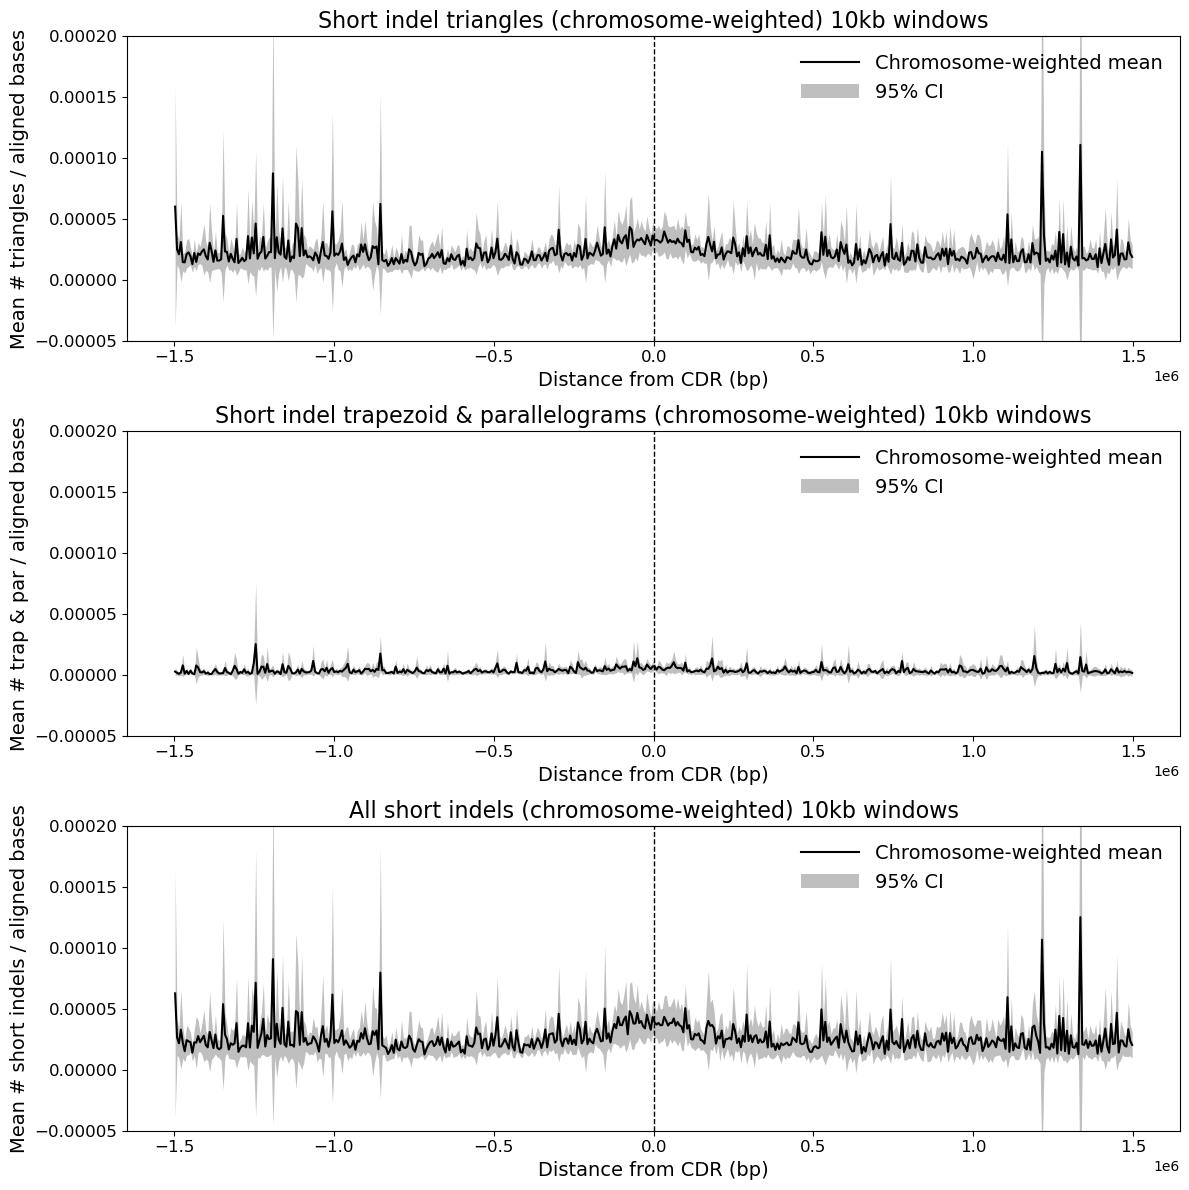

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05

window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# ----------------------------
# Filter and prepare dataframe
# ----------------------------
df = short_indel_10kb_df[short_indel_10kb_df["CDR_start"] != -1].copy()

# ----------------------------
# Drop windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["SV_end"] - df["SV_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]
df = df[df["aligned_fraction"] >= 0.2].copy()

# Compute combined rates
df["trap_par_rate"] = df["par_rate_aln_bases"] + df["trap_rate_aln_bases"]

rate_columns = [
    "tri_rate_aln_bases",
    "trap_par_rate",
    "all_rate_aln_bases"
]

# Clean invalid values
df[rate_columns] = df[rate_columns].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Plot labels
# ----------------------------
plot_titles = [
    "Short indel triangles (chromosome-weighted) 10kb windows",
    "Short indel trapezoid & parallelograms (chromosome-weighted) 10kb windows",
    "All short indels (chromosome-weighted) 10kb windows"
]
y_labels = [
    "Mean # triangles / aligned bases",
    "Mean # trap & par / aligned bases",
    "Mean # short indels / aligned bases"
]

# ----------------------------
# Create subplots
# ----------------------------
fig, axes = plt.subplots(len(rate_columns), 1, figsize=(12, 12))

for ax, rate_col, title, y_label in zip(axes, rate_columns, plot_titles, y_labels):

    # ------------------------------------------------
    # Step 1: count windows per chromosome per bin
    # ------------------------------------------------
    win_counts = (
        df.groupby(["distance_bin", "chr"])
          .size()
          .reset_index(name="n_windows")
    )

    # Keep only chromosome-bin pairs with ≥20 windows
    valid_chrom_bins = win_counts[win_counts["n_windows"] >= 10][["distance_bin", "chr"]]

    # ------------------------------------------------
    # Step 2: mean per chromosome per bin (only valid bins)
    # ------------------------------------------------
    chrom_bin_means = (
        df.merge(valid_chrom_bins, on=["distance_bin", "chr"])
          .groupby(["distance_bin", "chr"])
          .agg(chrom_mean=(rate_col, "mean"))
          .reset_index()
    )

    # ------------------------------------------------
    # Step 3: mean across chromosomes per bin
    # ------------------------------------------------
    agg = (
        chrom_bin_means
        .groupby("distance_bin")
        .agg(
            mean_rate=("chrom_mean", "mean"),
            std_rate=("chrom_mean", "std"),
            n_chroms=("chrom_mean", "count")
        )
        .reset_index()
        .sort_values("distance_bin")
    )

    # ------------------------------------------------
    # Step 4: t-distribution CI (chromosomes = n)
    # ------------------------------------------------
    agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
    agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
    agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
    agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

    # ------------------------------------------------
    # Step 5: Plot
    # ------------------------------------------------
    ax.plot(
        agg["distance_bin"],
        agg["mean_rate"],
        color="black",
        linewidth=1.5,
        label="Chromosome-weighted mean"
    )

    valid = agg["n_chroms"] >= 2
    ax.fill_between(
        agg.loc[valid, "distance_bin"],
        agg.loc[valid, "ci_low"],
        agg.loc[valid, "ci_high"],
        color="black",
        alpha=0.25,
        linewidth=0,
        label="95% CI"
    )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel("Distance from CDR (bp)", fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=12)

    ax.legend(frameon=False, fontsize=14, handlelength=3, loc="upper right")
    ax.set_ylim(-0.00005, 0.0002)

plt.tight_layout()
plt.show()


In [57]:
print(agg[["distance_bin", "n_chroms", "tcrit"]].head(20))


    distance_bin  n_chroms     tcrit
0     -1497000.0        11  2.228139
1     -1491000.0        11  2.228139
2     -1485000.0        10  2.262157
3     -1479000.0        11  2.228139
4     -1473000.0        11  2.228139
5     -1467000.0        12  2.200985
6     -1461000.0        11  2.228139
7     -1455000.0        11  2.228139
8     -1449000.0        11  2.228139
9     -1443000.0        11  2.228139
10    -1437000.0        11  2.228139
11    -1431000.0        11  2.228139
12    -1425000.0        11  2.228139
13    -1419000.0        11  2.228139
14    -1413000.0        11  2.228139
15    -1407000.0        11  2.228139
16    -1401000.0        11  2.228139
17    -1395000.0        11  2.228139
18    -1389000.0        11  2.228139
19    -1383000.0        11  2.228139


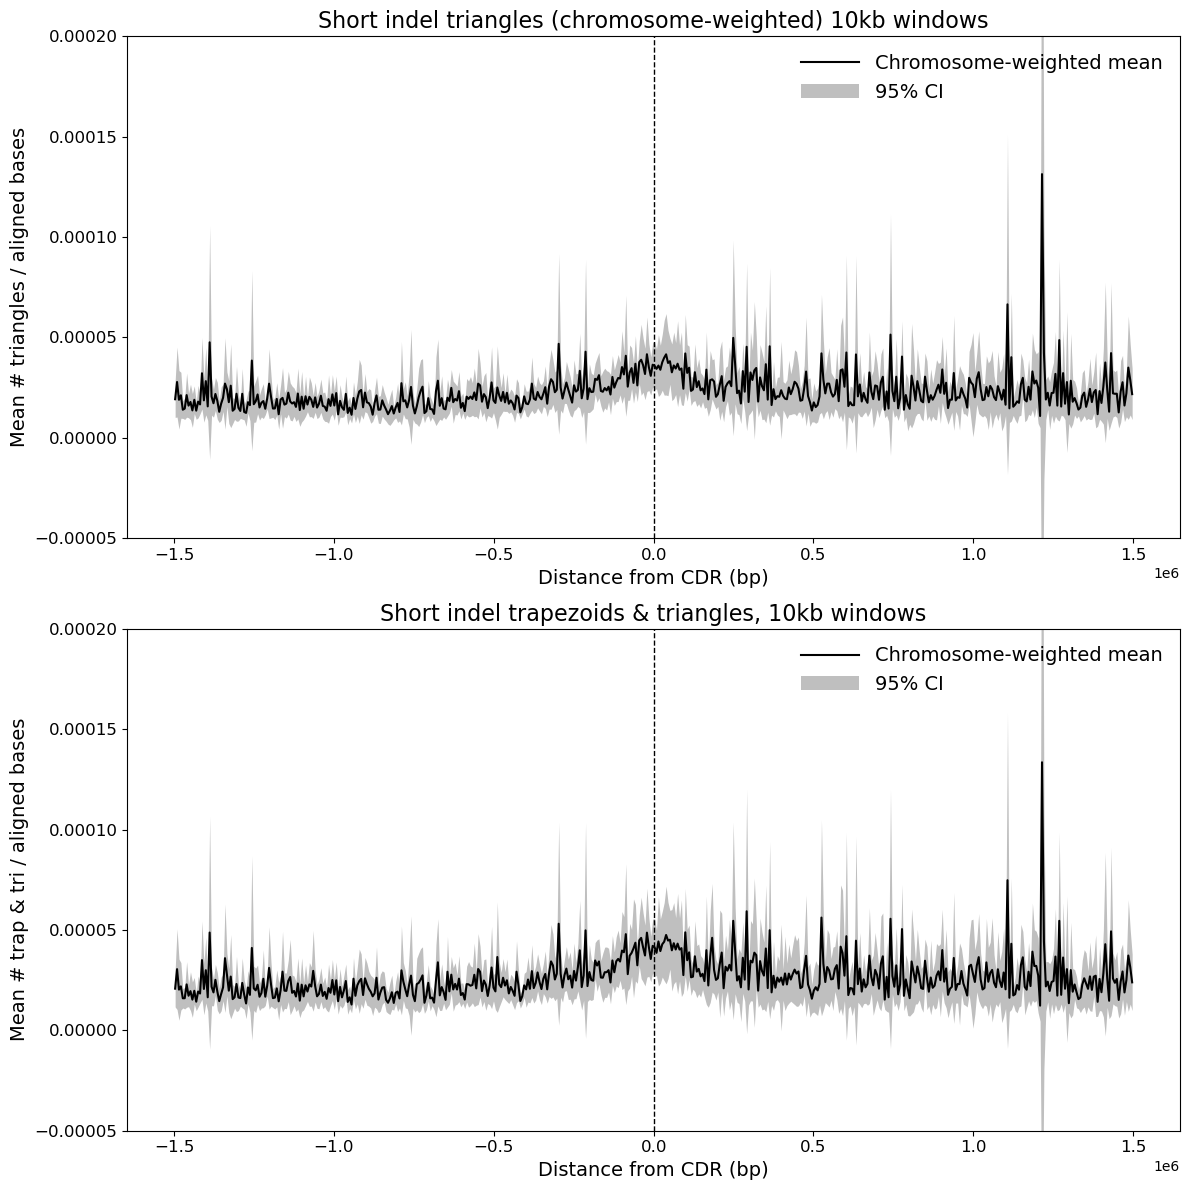

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05

window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# ----------------------------
# Filter and prepare dataframe
# ----------------------------
df = short_indel_10kb_df[short_indel_10kb_df["CDR_start"] != -1].copy()

# ----------------------------
# Drop windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["SV_end"] - df["SV_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]
df = df[df["aligned_fraction"] >= 0.2].copy()

# Compute combined rates
df["trap_tri_rate"] = df["trap_rate_aln_bases"] + df["tri_rate_aln_bases"]

rate_columns = [
    "tri_rate_aln_bases",
    "trap_tri_rate"
]

# Clean invalid values
df[rate_columns] = df[rate_columns].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Plot labels
# ----------------------------
plot_titles = [
    "Short indel triangles (chromosome-weighted) 10kb windows",
    "Short indel trapezoids & triangles, 10kb windows"]
y_labels = [
    "Mean # triangles / aligned bases",
    "Mean # trap & tri / aligned bases"]

# ----------------------------
# Create subplots
# ----------------------------
fig, axes = plt.subplots(len(rate_columns), 1, figsize=(12, 12))

for ax, rate_col, title, y_label in zip(axes, rate_columns, plot_titles, y_labels):

    # ------------------------------------------------
    # Step 1: count windows per chromosome per bin
    # ------------------------------------------------
    win_counts = (
        df.groupby(["distance_bin", "chr"])
          .size()
          .reset_index(name="n_windows")
    )

    # Keep only chromosome-bin pairs with ≥50 windows
    valid_chrom_bins = win_counts[win_counts["n_windows"] >= 50][["distance_bin", "chr"]]

    # ------------------------------------------------
    # Step 2: mean per chromosome per bin (only valid bins)
    # ------------------------------------------------
    chrom_bin_means = (
        df.merge(valid_chrom_bins, on=["distance_bin", "chr"])
          .groupby(["distance_bin", "chr"])
          .agg(chrom_mean=(rate_col, "mean"))
          .reset_index()
    )

    # ------------------------------------------------
    # Step 3: mean across chromosomes per bin
    # ------------------------------------------------
    agg = (
        chrom_bin_means
        .groupby("distance_bin")
        .agg(
            mean_rate=("chrom_mean", "mean"),
            std_rate=("chrom_mean", "std"),
            n_chroms=("chrom_mean", "count")
        )
        .reset_index()
        .sort_values("distance_bin")
    )

    # ------------------------------------------------
    # Step 4: t-distribution CI (chromosomes = n)
    # ------------------------------------------------
    agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
    agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
    agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
    agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

    # ------------------------------------------------
    # Step 5: Plot
    # ------------------------------------------------
    ax.plot(
        agg["distance_bin"],
        agg["mean_rate"],
        color="black",
        linewidth=1.5,
        label="Chromosome-weighted mean"
    )

    valid = agg["n_chroms"] >= 2
    ax.fill_between(
        agg.loc[valid, "distance_bin"],
        agg.loc[valid, "ci_low"],
        agg.loc[valid, "ci_high"],
        color="black",
        alpha=0.25,
        linewidth=0,
        label="95% CI"
    )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel("Distance from CDR (bp)", fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=12)

    ax.legend(frameon=False, fontsize=14, handlelength=3, loc="upper right")
    ax.set_ylim(-0.00005, 0.0002)

plt.tight_layout()
plt.show()

#### short indels, all chroms, 10kb windows

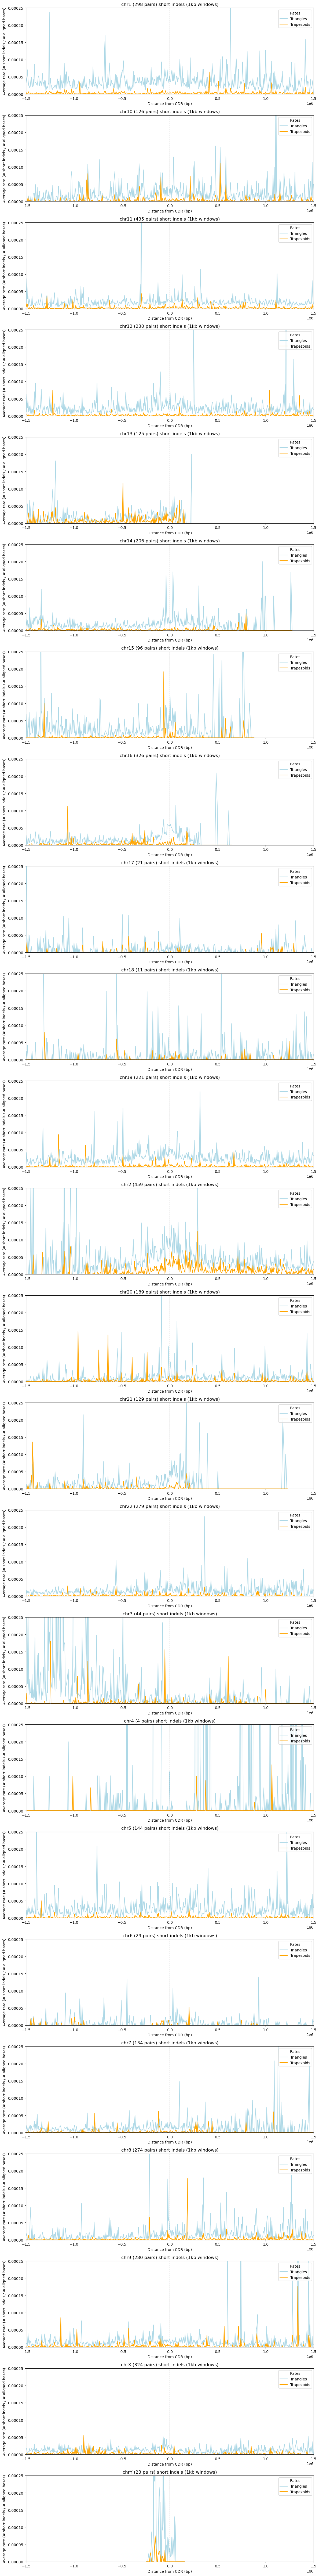

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter for valid CDR positions
df = short_indel_10kb_df[short_indel_10kb_df["CDR_start"] != -1].copy()

# ----------------------------
# Drop windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["SV_end"] - df["SV_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]
df = df[df["aligned_fraction"] >= 0.2].copy()

# combine trap and par rates 
df["trap_par_rate"] = (
    df["par_rate_aln_bases"] + df["trap_rate_aln_bases"]
)

# Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# Assign each row to a distance bin
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# List of chromosomes
chromosomes = sorted(df["chr"].unique())

# Assign a color to each rate
rate_colors = {
    "tri_rate_aln_bases": "lightblue",
    "trap_rate_aln_bases": "orange"
}
legend_labels = {
    "tri_rate_aln_bases": "Triangles",
    "trap_rate_aln_bases": "Trapezoids"
}
# Count unique sample pairs per chromosome
pair_counts = (
    df[["chr", "sample1", "sample2"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
    .to_dict()
)

# Create subplots: one panel per chromosome
fig, axes = plt.subplots(len(chromosomes), 1, figsize=(12, 4 * len(chromosomes)))

if len(chromosomes) == 1:
    axes = [axes]

for ax, chrom in zip(axes, chromosomes):
    chrom_df = df[df["chr"] == chrom]

    # Plot TRI, TRAP, PAR rates
    for rate_col in ["tri_rate_aln_bases", "trap_rate_aln_bases"]:
        agg = (
            chrom_df
            .groupby("distance_bin", as_index=False)
            .agg(mean_rate=(rate_col, "mean"))
            .sort_values("distance_bin")
        )
        ax.plot(
            agg["distance_bin"],
            agg["mean_rate"],
            color=rate_colors[rate_col],
            linewidth=1.5,
            label=legend_labels[rate_col]  # renamed
        )

    # Plot ALL rate in black, thicker line
    agg_all = (
        chrom_df
        .groupby("distance_bin", as_index=False)
        .agg(mean_rate=("all_rate_aln_bases", "mean"))
        .sort_values("distance_bin")
    )
    # ax.plot(
    #     agg_all["distance_bin"],
    #     agg_all["mean_rate"],
    #     color=rate_colors["all_rate"],
    #     linewidth=1.5,
    #     label="All Rate",
    #     zorder=10
    # )

    # Vertical line at CDR
    ax.axvline(0, color="black", linestyle="--", linewidth=1)

    # Axis limits, labels, title
    ax.set_xlim(-1500000, 1500000)
    ax.set_ylim(0, 0.00025)
    ax.set_ylabel("Average rate (# short indels / # aligned bases)")
    n_pairs = pair_counts.get(chrom, 0)
    ax.set_title(f"{chrom} ({n_pairs} pairs) short indels (1kb windows)")
    ax.legend(title="Rates", loc="upper right")

# x-axis label for the bottom panel
    ax.set_xlabel("Distance from CDR (bp)")

# Legend on the top panel
#axes[0].legend(title="Rates", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

### SNVs, 10 kb

In [4]:
def load_matching_beds_SNVs(chr_str, bed_folder, pairs_df, suffix):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 6, 7, 8, 9,10,16,17]
    col_names = [
        "contig",
        "window_start",
        "window_end",
        "SNV_counts",
        "SNV_rate",
        "CDR_contig",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_distance",
        "aligned_bases"
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):

        if not fname.endswith(suffix):
            continue

        base = fname.replace(suffix, "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )

        #if bed_df.shape[1] <= max(col_indices):
            #print("Unexpected column count:", bed_path, bed_df.shape[1])
            #continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)

In [5]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/aligned_bases_per_bed/SNVs_pairwise_10kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds_SNVs(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".aligned_bases.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
SNV_raw_10kb_df = pd.concat(all_chrom_dfs, ignore_index=True)
# Add aligned bases 
SNV_raw_10kb_df["SNV_rate_aln_bases"] = SNV_raw_10kb_df["SNV_counts"] / SNV_raw_10kb_df["aligned_bases"]

SNV_raw_10kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


contig  window_start  window_end  SNV_counts  SNV_rate  \
0  NA19909#2#CM094132.1     121895768   121905768           9    0.0009   
1  NA19909#2#CM094132.1     121905768   121915768           4    0.0004   
2  NA19909#2#CM094132.1     121915768   121925768           8    0.0008   
3  NA19909#2#CM094132.1     121925768   121935768           7    0.0007   
4  NA19909#2#CM094132.1     121935768   121945768          10    0.0010   

             CDR_contig  CDR_start    CDR_end CDR_status  CDR_distance  \
0  NA19909#2#CM094132.1  124208369  124227486        CDR       2302602   
1  NA19909#2#CM094132.1  124208369  124227486        CDR       2292602   
2  NA19909#2#CM094132.1  124208369  124227486        CDR       2282602   
3  NA19909#2#CM094132.1  124208369  124227486        CDR       2272602   
4  NA19909#2#CM094132.1  124208369  124227486        CDR       2262602   

   aligned_bases    sample1    sample2   chr  both_pairs_CDR  \
0           7625  HG01784.1  NA19909.2  chr1            True   
1          10000  HG01784.1  NA19909.2  chr1            True   
2           9901  HG01784.1  NA19909.2  chr1            True   
3           7382  HG01784.1  NA19909.2  chr1            True   
4           6600  HG01784.1  NA19909.2  chr1            True   

   SNV_rate_aln_bases  
0            0.001180  
1            0.000400  
2            0.000808  
3            0.000948  
4            0.001515

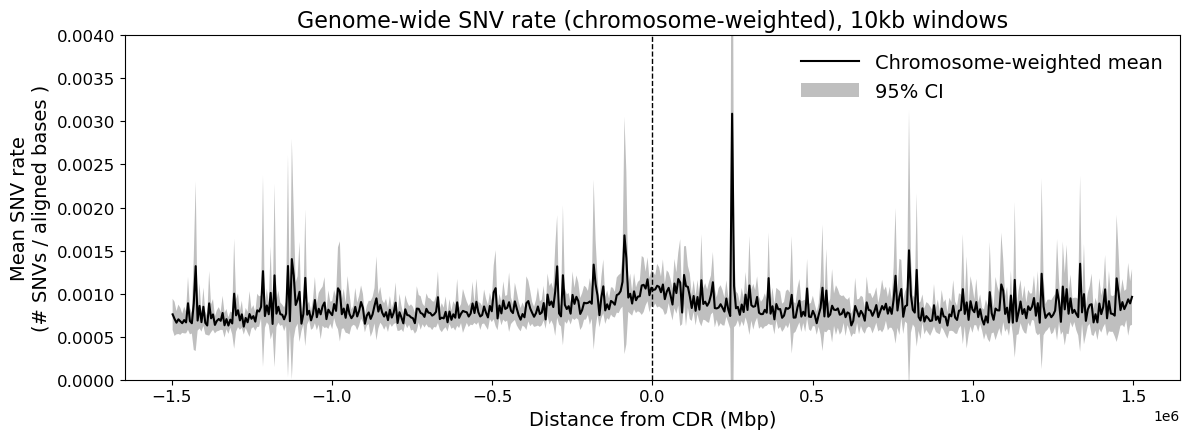

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# ----------------------------
# 2. Filter and prepare dataframe
# ----------------------------
df = SNV_raw_10kb_df[
    SNV_raw_10kb_df["CDR_start"] != -1
].copy()

# ----------------------------
# Drop chromosomes with < 10 sample pairs
# ----------------------------

df["sample_pair"] = (
    df[["sample1", "sample2"]]
    .astype(str)
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

pair_counts = (
    df[["chr", "sample_pair"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
)

valid_chroms = pair_counts[pair_counts >= 20].index

df = df[df["chr"].isin(valid_chroms)].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# 3. Chromosome-weighted averaging
# ----------------------------

# Step 1: mean SNV rate per chromosome per bin
chrom_bin_means = (
    df.groupby(["distance_bin", "chr"])
      .agg(chrom_mean=("SNV_rate_aln_bases", "mean"))
      .reset_index()
)

# Step 2: average across chromosomes (equal chrom weight)
agg = (
    chrom_bin_means
    .groupby("distance_bin")
    .agg(
        mean_rate=("chrom_mean", "mean"),
        std_rate=("chrom_mean", "std"),
        n_chroms=("chrom_mean", "count")
    )
    .reset_index()
    .sort_values("distance_bin")
)

# ----------------------------
# 4. Confidence intervals (t distribution)
# ----------------------------
agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

# ----------------------------
# 5. Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 4.5))

# Mean line
ax.plot(
    agg["distance_bin"],
    agg["mean_rate"],
    color="black",
    linewidth=1.5,
    label="Chromosome-weighted mean"
)

# CI band (require ≥2 chromosomes)
valid = agg["n_chroms"] >= 2
ax.fill_between(
    agg.loc[valid, "distance_bin"],
    agg.loc[valid, "ci_low"],
    agg.loc[valid, "ci_high"],
    color="black",
    alpha=0.25,
    linewidth=0,
    label="95% CI"
)

ax.set_xlabel("Distance from CDR (Mbp)",fontsize=14)
ax.set_ylabel("Mean SNV rate\n(# SNVs / aligned bases )",fontsize=14)
ax.set_title(
    "Genome-wide SNV rate (chromosome-weighted), 10kb windows",fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_ylim(0,0.004)
ax.legend(
    frameon=False,
    fontsize=14,
    handlelength=3
)
ax.axvline(0, color="black", linestyle="--", linewidth=1)

#ax.set_ylim(0,0.0025)
plt.tight_layout()
plt.show()

### Filtering chromosomes per bin before chrom-weighted average, removing windows with < 20% aligned 

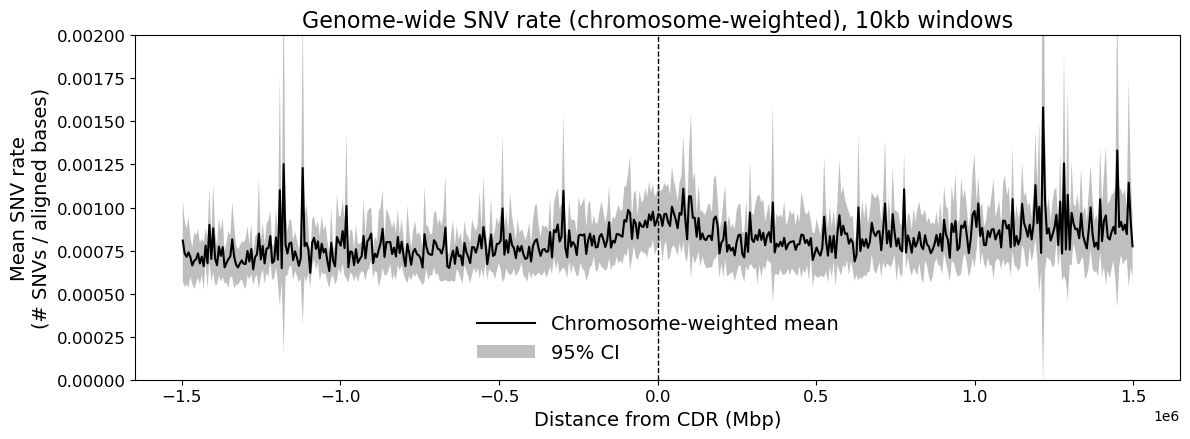

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# ----------------------------
# 2. Filter and prepare dataframe
# ----------------------------
df = SNV_raw_10kb_df[
    SNV_raw_10kb_df["CDR_start"] != -1
].copy()

# ----------------------------
# Filter windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["window_end"] - df["window_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]

df = df[df["aligned_fraction"] >= 0.2].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Step 1: compute per-bin, per-chromosome stats
# ----------------------------
# Group by bin and chromosome
chrom_bin_stats = (
    df.groupby(["distance_bin", "chr"])
      .agg(
          chrom_mean=("SNV_rate_aln_bases", "mean"),
          n_windows=("SNV_rate_aln_bases", "count")
      )
      .reset_index()
)

# ----------------------------
# Step 2: filter chromosomes per-bin
# ----------------------------
# Only keep chromosomes with ≥50 windows in that bin
chrom_bin_stats = chrom_bin_stats[chrom_bin_stats["n_windows"] >= 20]

# ----------------------------
# Step 3: chromosome-weighted mean per bin
# ----------------------------
agg = (
    chrom_bin_stats.groupby("distance_bin")
      .agg(
          mean_rate=("chrom_mean", "mean"),
          std_rate=("chrom_mean", "std"),
          n_chroms=("chrom_mean", "count")
      )
      .reset_index()
      .sort_values("distance_bin")
)

# ----------------------------
# Step 4: Confidence intervals (t distribution)
# ----------------------------
agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

# ----------------------------
# Step 5: Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 4.5))

# Mean line
ax.plot(
    agg["distance_bin"],
    agg["mean_rate"],
    color="black",
    linewidth=1.5,
    label="Chromosome-weighted mean"
)

# CI band (require ≥2 chromosomes)
valid = agg["n_chroms"] >= 2
ax.fill_between(
    agg.loc[valid, "distance_bin"],
    agg.loc[valid, "ci_low"],
    agg.loc[valid, "ci_high"],
    color="black",
    alpha=0.25,
    linewidth=0,
    label="95% CI"
)

ax.set_xlabel("Distance from CDR (Mbp)", fontsize=14)
ax.set_ylabel("Mean SNV rate\n(# SNVs / aligned bases)", fontsize=14)
ax.set_title("Genome-wide SNV rate (chromosome-weighted), 10kb windows", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_ylim(0, 0.002)
ax.legend(
    frameon=False,
    fontsize=14,
    handlelength=3,          # top of the plot
    ncol=1                       # number of columns in legend
)
ax.axvline(0, color="black", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


In [7]:
### Inspect remaining peaks 

N = 1  # number of top bins to inspect

top_bins = (
    agg
    .sort_values("mean_rate", ascending=False)
    .head(N)
)

print("Top bins by chromosome-weighted mean rate:")
print(top_bins[["distance_bin", "mean_rate", "n_chroms"]])

top_bin_values = top_bins["distance_bin"].values

top_chrom_stats = (
    chrom_bin_stats
    .loc[chrom_bin_stats["distance_bin"].isin(top_bin_values)]
    .sort_values(["distance_bin", "chrom_mean"], ascending=[True, False])
)

print("\nPer-chromosome rates for top bins:")
print(top_chrom_stats)

bin_window_summary = (
    top_chrom_stats
    .groupby("distance_bin")
    .agg(
        total_windows=("n_windows", "sum"),
        n_chroms=("chr", "nunique")
    )
    .reset_index()
)

print("\nTotal contributing windows per top bin:")
print(bin_window_summary)

for bin_val in top_bin_values:
    print(f"\n=== Distance bin: {bin_val/1e6:.3f} Mb ===")

    sub = top_chrom_stats[top_chrom_stats["distance_bin"] == bin_val]

    print(
        sub[["chr", "chrom_mean", "n_windows"]]
        .to_string(index=False)
    )

    print(f"Total windows: {sub['n_windows'].sum()}")


Top bins by chromosome-weighted mean rate:
     distance_bin  mean_rate  n_chroms
452     1215000.0   0.001582        12

Per-chromosome rates for top bins:
       distance_bin    chr  chrom_mean  n_windows
10045     1215000.0  chr12    0.009653         99
10060     1215000.0   chrX    0.001159        182
10049     1215000.0  chr19    0.001138        126
10044     1215000.0  chr11    0.001037        373
10043     1215000.0  chr10    0.000950         74
10050     1215000.0   chr2    0.000916        344
10052     1215000.0  chr22    0.000903         26
10042     1215000.0   chr1    0.000874         96
10059     1215000.0   chr9    0.000711         22
10055     1215000.0   chr5    0.000578         62
10051     1215000.0  chr20    0.000574         64
10058     1215000.0   chr8    0.000484        199

Total contributing windows per top bin:
   distance_bin  total_windows  n_chroms
0     1215000.0           1667        12

=== Distance bin: 1.215 Mb ===
  chr  chrom_mean  n_windows
chr12    

In [9]:
target_bin = 1215000.0

chr12_bin_df = (
    df[
        (df["chr"] == "chr12") &
        (df["distance_bin"] == target_bin)
    ]
    .sort_values("SNV_rate_aln_bases", ascending=False)
)

chr12_bin_df


contig  window_start  window_end  SNV_counts  SNV_rate  \
1414195  HG01928#2#CM089010.1      34729691    34739691         356    0.0356   
1413058  HG01928#2#CM089010.1      34729691    34739691         356    0.0356   
1377296  HG01928#2#CM089010.1      34729691    34739691         356    0.0356   
1404409  HG01928#2#CM089010.1      34729691    34739691         356    0.0356   
1482091  HG01928#2#CM089010.1      34729691    34739691         356    0.0356   
...                       ...           ...         ...         ...       ...   
1400868  HG02273#2#CM087038.1      36555825    36565825           1    0.0001   
1375508  HG01071#1#CM089121.1      34798105    34808105           0    0.0000   
1478613  HG00423#2#CM089421.1      34950991    34960991           0    0.0000   
1476034  HG02922#1#CM087004.1      35705710    35715710           0    0.0000   
1476426  HG03521#1#CM094418.1      35402625    35412625           0    0.0000   

                   CDR_contig  CDR_start   CDR_end CDR_status  CDR_distance  \
1414195  HG01928#2#CM089010.1   35955506  35961939        CDR       1215816   
1413058  HG01928#2#CM089010.1   35955506  35961939        CDR       1215816   
1377296  HG01928#2#CM089010.1   35955506  35961939        CDR       1215816   
1404409  HG01928#2#CM089010.1   35955506  35961939        CDR       1215816   
1482091  HG01928#2#CM089010.1   35955506  35961939        CDR       1215816   
...                       ...        ...       ...        ...           ...   
1400868  HG02273#2#CM087038.1   37783657  37829584        CDR       1217833   
1375508  HG01071#1#CM089121.1   36021526  36029300        CDR       1213422   
1478613  HG00423#2#CM089421.1   36176766  36197810        CDR       1215776   
1476034  HG02922#1#CM087004.1   36929419  37049675        CDR       1213710   
1476426  HG03521#1#CM094418.1   36629044  36638066        CDR       1216420   

         aligned_bases    sample1    sample2    chr  both_pairs_CDR  \
1414195           3155  HG01928.2  HG01943.2  chr12            True   
1413058           3155  HG00735.1  HG01928.2  chr12            True   
1377296           3155  HG01928.2  HG01943.1  chr12            True   
1404409           3155  HG01928.2  HG02004.2  chr12            True   
1482091           3155  HG00733.1  HG01928.2  chr12           False   
...                ...        ...        ...    ...             ...   
1400868           9146  HG01934.1  HG02273.2  chr12            True   
1375508          10000  HG01071.1  HG02004.2  chr12            True   
1478613          10000  HG00423.2  HG00544.1  chr12            True   
1476034          10000  HG02922.1  HG03521.1  chr12            True   
1476426          10000  HG02922.1  HG03521.1  chr12            True   

         SNV_rate_aln_bases  window_size  aligned_fraction  distance_bin  
1414195            0.112837        10000            0.3155     1215000.0  
1413058            0.112837        10000            0.3155     1215000.0  
1377296            0.112837        10000            0.3155     1215000.0  
1404409            0.112837        10000            0.3155     1215000.0  
1482091            0.112837        10000            0.3155     1215000.0  
...                     ...          ...               ...           ...  
1400868            0.000109        10000            0.9146     1215000.0  
1375508            0.000000        10000            1.0000     1215000.0  
1478613            0.000000        10000            1.0000     1215000.0  
1476034            0.000000        10000            1.0000     1215000.0  
1476426            0.000000        10000            1.0000     1215000.0  

[99 rows x 19 columns]

#### Using the median instead of mean

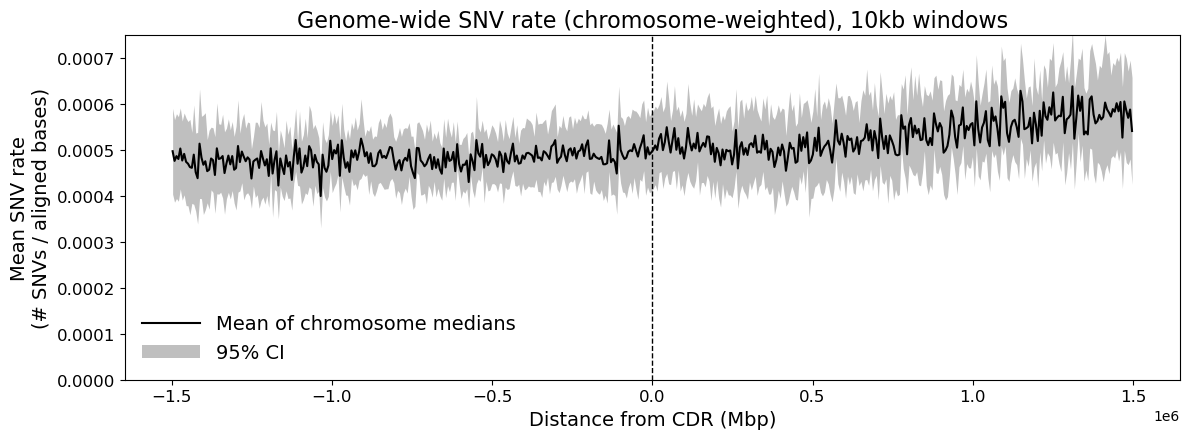

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# ----------------------------
# 2. Filter and prepare dataframe
# ----------------------------
df = SNV_raw_10kb_df[
    SNV_raw_10kb_df["CDR_start"] != -1
].copy()

# ----------------------------
# Filter windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["window_end"] - df["window_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]

df = df[df["aligned_fraction"] >= 0.2].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Step 1: compute per-bin, per-chromosome stats
# ----------------------------
# Group by bin and chromosome
chrom_bin_stats = (
    df.groupby(["distance_bin", "chr"])
      .agg(
          chrom_median=("SNV_rate_aln_bases", "median"),
          n_windows=("SNV_rate_aln_bases", "count")
      )
      .reset_index()
)


# ----------------------------
# Step 2: filter chromosomes per-bin
# ----------------------------
# Only keep chromosomes with ≥50 windows in that bin
chrom_bin_stats = chrom_bin_stats[chrom_bin_stats["n_windows"] >= 20]

# ----------------------------
# Step 3: chromosome-weighted mean per bin
agg = (
    chrom_bin_stats.groupby("distance_bin")
      .agg(
          mean_rate=("chrom_median", "mean"),
          std_rate=("chrom_median", "std"),
          n_chroms=("chrom_median", "count")
      )
      .reset_index()
      .sort_values("distance_bin")
)


# ----------------------------
# Step 4: Confidence intervals (t distribution)
# ----------------------------
agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

# ----------------------------
# Step 5: Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 4.5))

# Mean line
ax.plot(
    agg["distance_bin"],
    agg["mean_rate"],
    color="black",
    linewidth=1.5,
    label="Mean of chromosome medians"
)


# CI band (require ≥2 chromosomes)
valid = agg["n_chroms"] >= 2
ax.fill_between(
    agg.loc[valid, "distance_bin"],
    agg.loc[valid, "ci_low"],
    agg.loc[valid, "ci_high"],
    color="black",
    alpha=0.25,
    linewidth=0,
    label="95% CI"
)

ax.set_xlabel("Distance from CDR (Mbp)", fontsize=14)
ax.set_ylabel("Mean SNV rate\n(# SNVs / aligned bases)", fontsize=14)
ax.set_title("Genome-wide SNV rate (chromosome-weighted), 10kb windows", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_ylim(0, 0.00075)
ax.legend(
    frameon=False,
    fontsize=14,
    handlelength=3,          # top of the plot
    ncol=1                       # number of columns in legend
)
ax.axvline(0, color="black", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


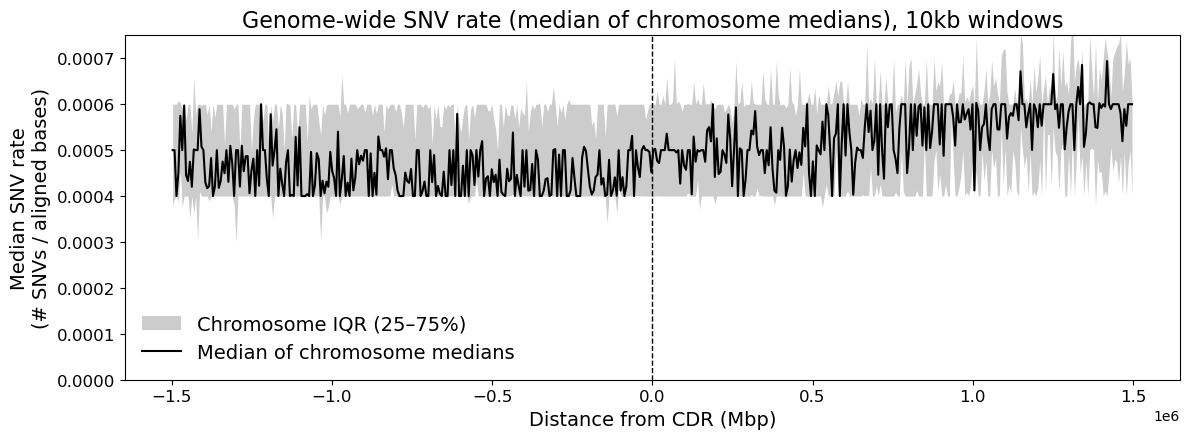

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Parameters
# ----------------------------
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

# ----------------------------
# 1. Define bins and bin centers
# ----------------------------
bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# ----------------------------
# 2. Filter and prepare dataframe
# ----------------------------
df = SNV_raw_10kb_df[
    SNV_raw_10kb_df["CDR_start"] != -1
].copy()

df["window_size"] = df["window_end"] - df["window_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]
df = df[df["aligned_fraction"] >= 0.2].copy()

df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace(
    [np.inf, -np.inf], np.nan
)

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Step 1: per-bin, per-chromosome medians
# ----------------------------
chrom_bin_stats = (
    df.groupby(["distance_bin", "chr"])
      .agg(
          chrom_median=("SNV_rate_aln_bases", "median"),
          n_windows=("SNV_rate_aln_bases", "count")
      )
      .reset_index()
)

# ----------------------------
# Step 2: filter chromosomes per-bin
# ----------------------------
chrom_bin_stats = chrom_bin_stats[
    chrom_bin_stats["n_windows"] >= 20
]

# ----------------------------
# Step 3: median + IQR across chromosomes
# ----------------------------
agg = (
    chrom_bin_stats.groupby("distance_bin")["chrom_median"]
      .agg(
          median_rate="median",
          q25=lambda x: np.percentile(x, 25),
          q75=lambda x: np.percentile(x, 75),
          n_chroms="count"
      )
      .reset_index()
      .sort_values("distance_bin")
)

# ----------------------------
# Step 4: Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 4.5))

# IQR ribbon (only where ≥2 chromosomes)
valid = agg["n_chroms"] >= 2
ax.fill_between(
    agg.loc[valid, "distance_bin"],
    agg.loc[valid, "q25"],
    agg.loc[valid, "q75"],
    color="black",
    alpha=0.20,
    linewidth=0,
    label="Chromosome IQR (25–75%)"
)

# Median line
ax.plot(
    agg["distance_bin"],
    agg["median_rate"],
    color="black",
    linewidth=1.5,
    label="Median of chromosome medians"
)

ax.set_xlabel("Distance from CDR (Mbp)", fontsize=14)
ax.set_ylabel("Median SNV rate\n(# SNVs / aligned bases)", fontsize=14)
ax.set_title(
    "Genome-wide SNV rate (median of chromosome medians), 10kb windows",
    fontsize=16
)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_ylim(0, 0.00075)

ax.legend(frameon=False, fontsize=14)
ax.axvline(0, color="black", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()



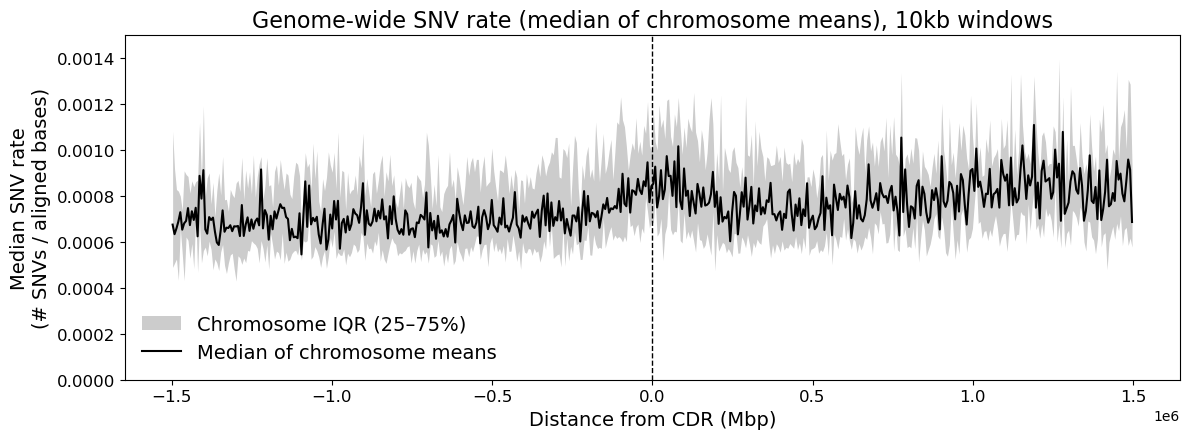

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Parameters
# ----------------------------
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

# ----------------------------
# 1. Define bins and bin centers
# ----------------------------
bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# ----------------------------
# 2. Filter and prepare dataframe
# ----------------------------
df = SNV_raw_10kb_df[
    SNV_raw_10kb_df["CDR_start"] != -1
].copy()

df["window_size"] = df["window_end"] - df["window_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]
df = df[df["aligned_fraction"] >= 0.2].copy()

df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace(
    [np.inf, -np.inf], np.nan
)

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Step 1: per-bin, per-chromosome means
# ----------------------------
chrom_bin_stats = (
    df.groupby(["distance_bin", "chr"])
      .agg(
          chrom_mean=("SNV_rate_aln_bases", "mean"),
          n_windows=("SNV_rate_aln_bases", "count")
      )
      .reset_index()
)

# ----------------------------
# Step 2: filter chromosomes per-bin
# ----------------------------
chrom_bin_stats = chrom_bin_stats[
    chrom_bin_stats["n_windows"] >= 20
]

# ----------------------------
# Step 3: median + IQR across chromosome means
# ----------------------------
agg = (
    chrom_bin_stats.groupby("distance_bin")["chrom_mean"]
      .agg(
          median_rate="median",
          q25=lambda x: np.percentile(x, 25),
          q75=lambda x: np.percentile(x, 75),
          n_chroms="count"
      )
      .reset_index()
      .sort_values("distance_bin")
)

# ----------------------------
# Step 4: Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 4.5))

# IQR ribbon (≥2 chromosomes)
valid = agg["n_chroms"] >= 2
ax.fill_between(
    agg.loc[valid, "distance_bin"],
    agg.loc[valid, "q25"],
    agg.loc[valid, "q75"],
    color="black",
    alpha=0.20,
    linewidth=0,
    label="Chromosome IQR (25–75%)"
)

# Median line
ax.plot(
    agg["distance_bin"],
    agg["median_rate"],
    color="black",
    linewidth=1.5,
    label="Median of chromosome means"
)

ax.set_xlabel("Distance from CDR (Mbp)", fontsize=14)
ax.set_ylabel("Median SNV rate\n(# SNVs / aligned bases)", fontsize=14)
ax.set_title(
    "Genome-wide SNV rate (median of chromosome means), 10kb windows",
    fontsize=16
)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_ylim(0, 0.0015)

ax.legend(frameon=False, fontsize=14)
ax.axvline(0, color="black", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


KeyError: 'min_rate'

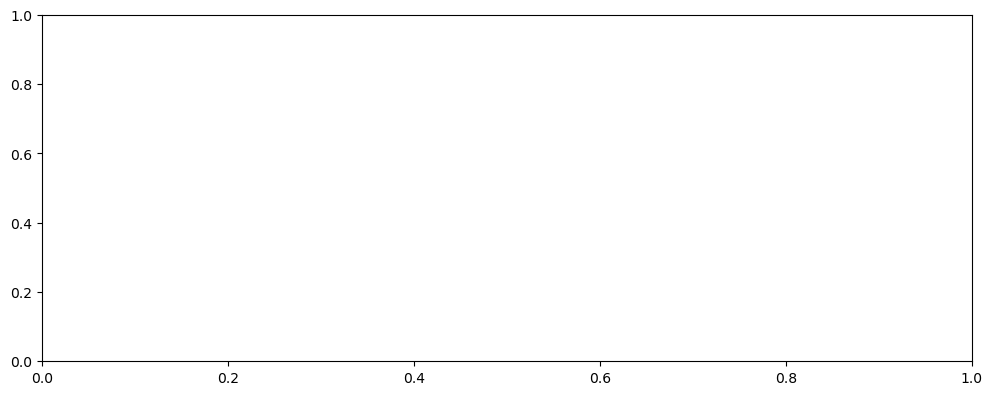

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Parameters
# ----------------------------
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

# ----------------------------
# 1. Define bins and bin centers
# ----------------------------
bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# ----------------------------
# 2. Filter and prepare dataframe
# ----------------------------
df = SNV_raw_10kb_df[
    SNV_raw_10kb_df["CDR_start"] != -1
].copy()

df["window_size"] = df["window_end"] - df["window_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]
df = df[df["aligned_fraction"] >= 0.2].copy()

df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace(
    [np.inf, -np.inf], np.nan
)

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Step 1: per-bin, per-chromosome means
# ----------------------------
chrom_bin_stats = (
    df.groupby(["distance_bin", "chr"])
      .agg(
          chrom_mean=("SNV_rate_aln_bases", "mean"),
          n_windows=("SNV_rate_aln_bases", "count")
      )
      .reset_index()
)

# ----------------------------
# Step 2: filter chromosomes per-bin
# ----------------------------
chrom_bin_stats = chrom_bin_stats[
    chrom_bin_stats["n_windows"] >= 20
]

# ----------------------------
# Step 3: median + IQR across chromosome means
# ----------------------------
# ----------------------------
# Step 3: median + full spread across chromosome means
# ----------------------------
agg = (
    chrom_bin_stats.groupby("distance_bin")["chrom_mean"]
      .agg(
          median_rate="median",
          min_rate="min",
          max_rate="max",
          n_chroms="count"
      )
      .reset_index()
      .sort_values("distance_bin")
)


# ----------------------------
# Step 4: Plot
# ----------------------------

fig, ax = plt.subplots(figsize=(12, 4.5))

valid = agg["n_chroms"] >= 2

# Full spread ribbon (min–max)
ax.fill_between(
    agg.loc[valid, "distance_bin"],
    agg.loc[valid, "min_rate"],
    agg.loc[valid, "max_rate"],
    color="black",
    alpha=0.15,
    linewidth=0,
    label="Chromosome range (min–max)"
)

# Median line
ax.plot(
    agg["distance_bin"],
    agg["median_rate"],
    color="black",
    linewidth=1.5,
    label="Median of chromosome means"
)

ax.set_xlabel("Distance from CDR (Mbp)", fontsize=14)
ax.set_ylabel("Median SNV rate\n(# SNVs / aligned bases)", fontsize=14)
ax.set_title(
    "Genome-wide SNV rate (median of chromosome means), 10kb windows",
    fontsize=16
)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_ylim(0, 0.0015)

ax.legend(frameon=False, fontsize=14)
ax.axvline(0, color="black", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


#### Per chrom

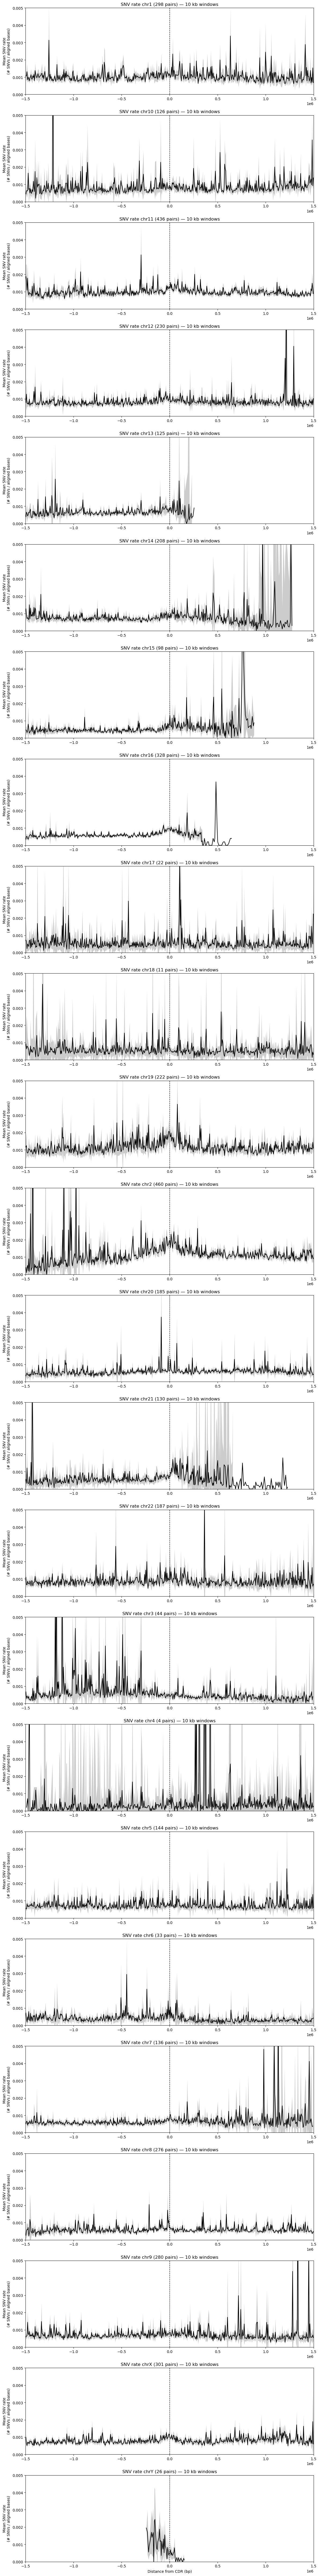

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05
window_range = 1_500_000
n_bins = 500

# ----------------------------
# Filter for valid CDR positions
# ----------------------------
df = SNV_raw_10kb_df[
    SNV_raw_10kb_df["CDR_start"] != -1
].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace(
    [np.inf, -np.inf], np.nan
)

# ----------------------------
# Filter windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["window_end"] - df["window_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]

df = df[df["aligned_fraction"] >= 0.2].copy()

# ----------------------------
# Define signed-distance bins
# ----------------------------
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Chromosomes
# ----------------------------
chromosomes = sorted(df["chr"].unique())

pair_counts = (
    df[["chr", "sample1", "sample2"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
    .to_dict()
)

# ----------------------------
# Plot
# ----------------------------
fig, axes = plt.subplots(
    len(chromosomes), 1,
    figsize=(12, 4 * len(chromosomes))
)

if len(chromosomes) == 1:
    axes = [axes]

for ax, chrom in zip(axes, chromosomes):
    chrom_df = df[df["chr"] == chrom]

    # ---- aggregate per bin ----
    agg = (
        chrom_df
        .groupby("distance_bin")
        .agg(
            mean_rate=("SNV_rate_aln_bases", "mean"),
            std_rate=("SNV_rate_aln_bases", "std"),
            n=("SNV_rate_aln_bases", "count")
        )
        .reset_index()
        .sort_values("distance_bin")
    )

    # ---- CI computation ----
    agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n"] - 1)
    agg["se"] = agg["std_rate"] / np.sqrt(agg["n"])
    agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
    agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

    # ---- mean line ----
    ax.plot(
        agg["distance_bin"],
        agg["mean_rate"],
        color="black",
        linewidth=1.5
    )

    # ---- CI band (n ≥ 2) ----
    valid = agg["n"] >= 2
    ax.fill_between(
        agg.loc[valid, "distance_bin"],
        agg.loc[valid, "ci_low"],
        agg.loc[valid, "ci_high"],
        color="grey",
        alpha=0.4,
        linewidth=0
    )

    # ---- formatting ----
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlim(-1_500_000, 1_500_000)
    ax.set_ylim(0, .005)
    ax.set_ylabel("Mean SNV rate\n(# SNVs / aligned bases)")

    n_pairs = pair_counts.get(chrom, 0)
    ax.set_title(f"SNV rate {chrom} ({n_pairs} pairs) — 10 kb windows")

axes[-1].set_xlabel("Distance from CDR (bp)")

plt.tight_layout()
plt.show()

### Short indels, 50 kb 

In [45]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/aligned_bases_per_bed/short_indels_pairwise_50kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_bed_aln(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".aligned_bases.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
short_indel_50kb_df = pd.concat(all_chrom_dfs, ignore_index=True)

short_indel_50kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  NA19909#2#CM094132.1  121895768  121945768           0       0.0   
1  NA19909#2#CM094132.1  121945768  121995768           0       0.0   
2  NA19909#2#CM094132.1  121995768  122045768           0       0.0   
3  NA19909#2#CM094132.1  122045768  122095768           0       0.0   
4  NA19909#2#CM094132.1  122095768  122145768           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate            CDR_contig  \
0            0        0.0           0   0.00000  NA19909#2#CM094132.1   
1            0        0.0           0   0.00000  NA19909#2#CM094132.1   
2            0        0.0           1   0.00002  NA19909#2#CM094132.1   
3            0        0.0           1   0.00002  NA19909#2#CM094132.1   
4            0        0.0           5   0.00010  NA19909#2#CM094132.1   

   CDR_start    CDR_end CDR_status  CDR_distance  aligned_bases    sample1  \
0  124208369  124227486        CDR       2262602          41508  HG01784.1   
1  124208369  124227486        CDR       2212602          45511  HG01784.1   
2  124208369  124227486        CDR       2162602          49817  HG01784.1   
3  124208369  124227486        CDR       2112602          49240  HG01784.1   
4  124208369  124227486        CDR       2062602          41765  HG01784.1   

     sample2   chr  both_pairs_CDR  
0  NA19909.2  chr1            True  
1  NA19909.2  chr1            True  
2  NA19909.2  chr1            True  
3  NA19909.2  chr1            True  
4  NA19909.2  chr1            True

In [49]:
# add rate for all variants
short_indel_50kb_df["all_counts"] = (
    short_indel_50kb_df["par_counts"]
    + short_indel_50kb_df["trap_counts"]
    + short_indel_50kb_df["tri_counts"]
)

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
short_indel_50kb_df["CDR_distance"] = -short_indel_50kb_df["CDR_distance"]

short_indel_50kb_df["tri_rate_aln_bases"] = short_indel_50kb_df["tri_counts"] / short_indel_50kb_df["aligned_bases"]
short_indel_50kb_df["par_rate_aln_bases"] = short_indel_50kb_df["par_counts"] / short_indel_50kb_df["aligned_bases"]
short_indel_50kb_df["trap_rate_aln_bases"] = short_indel_50kb_df["trap_counts"] / short_indel_50kb_df["aligned_bases"]

short_indel_50kb_df["all_rate_aln_bases"] = short_indel_50kb_df["all_counts"] / short_indel_50kb_df["aligned_bases"]
short_indel_50kb_df.head()

SV_contig   SV_start     SV_end  par_counts  par_rate  \
0  NA19909#2#CM094132.1  121895768  121945768           0       0.0   
1  NA19909#2#CM094132.1  121945768  121995768           0       0.0   
2  NA19909#2#CM094132.1  121995768  122045768           0       0.0   
3  NA19909#2#CM094132.1  122045768  122095768           0       0.0   
4  NA19909#2#CM094132.1  122095768  122145768           0       0.0   

   trap_counts  trap_rate  tri_counts  tri_rate            CDR_contig  ...  \
0            0        0.0           0   0.00000  NA19909#2#CM094132.1  ...   
1            0        0.0           0   0.00000  NA19909#2#CM094132.1  ...   
2            0        0.0           1   0.00002  NA19909#2#CM094132.1  ...   
3            0        0.0           1   0.00002  NA19909#2#CM094132.1  ...   
4            0        0.0           5   0.00010  NA19909#2#CM094132.1  ...   

   aligned_bases    sample1    sample2   chr  both_pairs_CDR all_counts  \
0          41508  HG01784.1  NA19909.2  chr1            True          0   
1          45511  HG01784.1  NA19909.2  chr1            True          0   
2          49817  HG01784.1  NA19909.2  chr1            True          1   
3          49240  HG01784.1  NA19909.2  chr1            True          1   
4          41765  HG01784.1  NA19909.2  chr1            True          5   

  tri_rate_aln_bases par_rate_aln_bases  trap_rate_aln_bases  \
0            0.00000                0.0                  0.0   
1            0.00000                0.0                  0.0   
2            0.00002                0.0                  0.0   
3            0.00002                0.0                  0.0   
4            0.00012                0.0                  0.0   

   all_rate_aln_bases  
0             0.00000  
1             0.00000  
2             0.00002  
3             0.00002  
4             0.00012  

[5 rows x 24 columns]

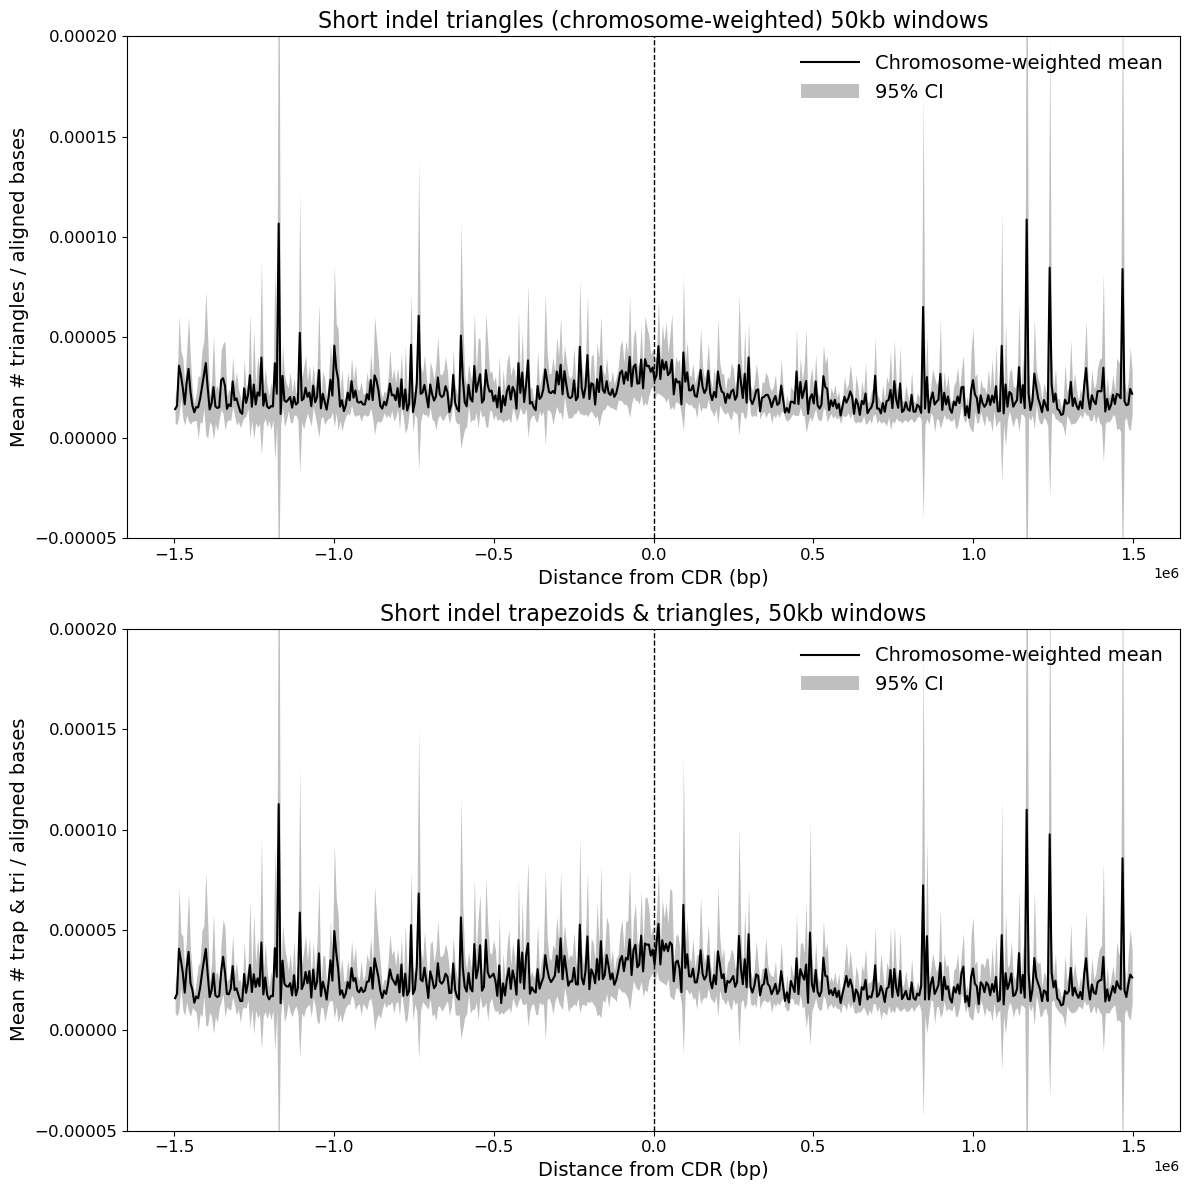

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05

window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# ----------------------------
# Filter and prepare dataframe
# ----------------------------
df = short_indel_50kb_df[short_indel_50kb_df["CDR_start"] != -1].copy()


# ----------------------------
# Drop chromosomes with <20 sample pairs
# ----------------------------
df["sample_pair"] = (
    df[["sample1", "sample2"]]
    .astype(str)
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

pair_counts = (
    df[["chr", "sample_pair"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
)

# ----------------------------
# Drop windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["SV_end"] - df["SV_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]
df = df[df["aligned_fraction"] >= 0.2].copy()

# Compute combined rates
df["trap_tri_rate"] = df["trap_rate_aln_bases"] + df["tri_rate_aln_bases"]

rate_columns = [
    "tri_rate_aln_bases",
    "trap_tri_rate"
]

# Clean invalid values
df[rate_columns] = df[rate_columns].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Plot labels
# ----------------------------
plot_titles = [
    "Short indel triangles (chromosome-weighted) 50kb windows",
    "Short indel trapezoids & triangles, 50kb windows"]
y_labels = [
    "Mean # triangles / aligned bases",
    "Mean # trap & tri / aligned bases"]

# ----------------------------
# Create subplots
# ----------------------------
fig, axes = plt.subplots(len(rate_columns), 1, figsize=(12, 12))

for ax, rate_col, title, y_label in zip(axes, rate_columns, plot_titles, y_labels):

    # ------------------------------------------------
    # Step 1: count windows per chromosome per bin
    # ------------------------------------------------
    win_counts = (
        df.groupby(["distance_bin", "chr"])
          .size()
          .reset_index(name="n_windows")
    )

    # Keep only chromosome-bin pairs with ≥50 windows
    valid_chrom_bins = win_counts[win_counts["n_windows"] >= 10][["distance_bin", "chr"]]

    # ------------------------------------------------
    # Step 2: mean per chromosome per bin (only valid bins)
    # ------------------------------------------------
    chrom_bin_means = (
        df.merge(valid_chrom_bins, on=["distance_bin", "chr"])
          .groupby(["distance_bin", "chr"])
          .agg(chrom_mean=(rate_col, "mean"))
          .reset_index()
    )

    # ------------------------------------------------
    # Step 3: mean across chromosomes per bin
    # ------------------------------------------------
    agg = (
        chrom_bin_means
        .groupby("distance_bin")
        .agg(
            mean_rate=("chrom_mean", "mean"),
            std_rate=("chrom_mean", "std"),
            n_chroms=("chrom_mean", "count")
        )
        .reset_index()
        .sort_values("distance_bin")
    )

    # ------------------------------------------------
    # Step 4: t-distribution CI (chromosomes = n)
    # ------------------------------------------------
    agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
    agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
    agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
    agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

    # ------------------------------------------------
    # Step 5: Plot
    # ------------------------------------------------
    ax.plot(
        agg["distance_bin"],
        agg["mean_rate"],
        color="black",
        linewidth=1.5,
        label="Chromosome-weighted mean"
    )

    valid = agg["n_chroms"] >= 2
    ax.fill_between(
        agg.loc[valid, "distance_bin"],
        agg.loc[valid, "ci_low"],
        agg.loc[valid, "ci_high"],
        color="black",
        alpha=0.25,
        linewidth=0,
        label="95% CI"
    )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel("Distance from CDR (bp)", fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=12)

    ax.legend(frameon=False, fontsize=14, handlelength=3, loc="upper right")
    ax.set_ylim(-0.00005, 0.0002)

plt.tight_layout()
plt.show()

In [55]:
print(agg[["distance_bin", "n_chroms", "tcrit"]].head(20))


    distance_bin  n_chroms      tcrit
0     -1497000.0         1        NaN
1     -1485000.0         1        NaN
2     -1479000.0         2  12.706205
3     -1473000.0         1        NaN
4     -1461000.0         1        NaN
5     -1455000.0         2  12.706205
6     -1449000.0         1        NaN
7     -1443000.0         2  12.706205
8     -1437000.0         1        NaN
9     -1431000.0         2  12.706205
10    -1425000.0         1        NaN
11    -1419000.0         2  12.706205
12    -1413000.0         1        NaN
13    -1407000.0         1        NaN
14    -1401000.0         1        NaN
15    -1395000.0         1        NaN
16    -1389000.0         1        NaN
17    -1383000.0         2  12.706205
18    -1377000.0         3   4.302653
19    -1371000.0         2  12.706205


### SNVs 50 kb windows 

In [52]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/aligned_bases_per_bed/SNVs_pairwise_50kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds_SNVs(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".aligned_bases.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
SNV_raw_50kb_df = pd.concat(all_chrom_dfs, ignore_index=True)
# Add aligned bases 
SNV_raw_50kb_df["SNV_rate_aln_bases"] = SNV_raw_50kb_df["SNV_counts"] / SNV_raw_50kb_df["aligned_bases"]

SNV_raw_50kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


contig  window_start  window_end  SNV_counts  SNV_rate  \
0  NA19909#2#CM094132.1     121895768   121945768          38   0.00076   
1  NA19909#2#CM094132.1     121945768   121995768          45   0.00090   
2  NA19909#2#CM094132.1     121995768   122045768          52   0.00104   
3  NA19909#2#CM094132.1     122045768   122095768          48   0.00096   
4  NA19909#2#CM094132.1     122095768   122145768         243   0.00486   

             CDR_contig  CDR_start    CDR_end CDR_status  CDR_distance  \
0  NA19909#2#CM094132.1  124208369  124227486        CDR       2262602   
1  NA19909#2#CM094132.1  124208369  124227486        CDR       2212602   
2  NA19909#2#CM094132.1  124208369  124227486        CDR       2162602   
3  NA19909#2#CM094132.1  124208369  124227486        CDR       2112602   
4  NA19909#2#CM094132.1  124208369  124227486        CDR       2062602   

   aligned_bases    sample1    sample2   chr  both_pairs_CDR  \
0          41508  HG01784.1  NA19909.2  chr1            True   
1          45511  HG01784.1  NA19909.2  chr1            True   
2          49817  HG01784.1  NA19909.2  chr1            True   
3          49240  HG01784.1  NA19909.2  chr1            True   
4          41765  HG01784.1  NA19909.2  chr1            True   

   SNV_rate_aln_bases  
0            0.000915  
1            0.000989  
2            0.001044  
3            0.000975  
4            0.005818

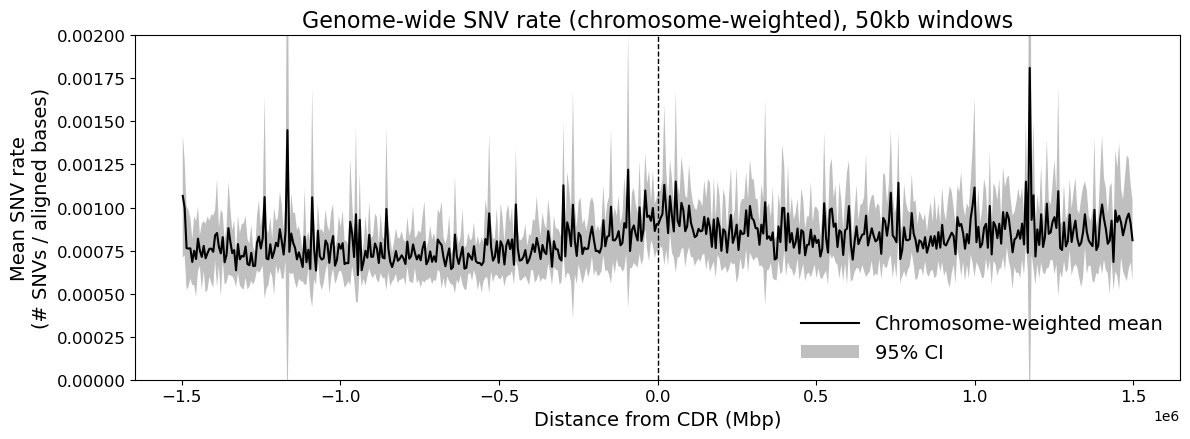

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# ----------------------------
# 2. Filter and prepare dataframe
# ----------------------------
df = SNV_raw_50kb_df[
    SNV_raw_50kb_df["CDR_start"] != -1
].copy()

# ----------------------------
# Filter windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["window_end"] - df["window_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]

df = df[df["aligned_fraction"] >= 0.2].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Step 1: compute per-bin, per-chromosome stats
# ----------------------------
# Group by bin and chromosome
chrom_bin_stats = (
    df.groupby(["distance_bin", "chr"])
      .agg(
          chrom_mean=("SNV_rate_aln_bases", "mean"),
          n_windows=("SNV_rate_aln_bases", "count")
      )
      .reset_index()
)

# ----------------------------
# Step 2: filter chromosomes per-bin
# ----------------------------
# Only keep chromosomes with ≥50 windows in that bin
chrom_bin_stats = chrom_bin_stats[chrom_bin_stats["n_windows"] >= 10]

# ----------------------------
# Step 3: chromosome-weighted mean per bin
# ----------------------------
agg = (
    chrom_bin_stats.groupby("distance_bin")
      .agg(
          mean_rate=("chrom_mean", "mean"),
          std_rate=("chrom_mean", "std"),
          n_chroms=("chrom_mean", "count")
      )
      .reset_index()
      .sort_values("distance_bin")
)

# ----------------------------
# Step 4: Confidence intervals (t distribution)
# ----------------------------
agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

# ----------------------------
# Step 5: Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 4.5))

# Mean line
ax.plot(
    agg["distance_bin"],
    agg["mean_rate"],
    color="black",
    linewidth=1.5,
    label="Chromosome-weighted mean"
)

# CI band (require ≥2 chromosomes)
valid = agg["n_chroms"] >= 2
ax.fill_between(
    agg.loc[valid, "distance_bin"],
    agg.loc[valid, "ci_low"],
    agg.loc[valid, "ci_high"],
    color="black",
    alpha=0.25,
    linewidth=0,
    label="95% CI"
)

ax.set_xlabel("Distance from CDR (Mbp)", fontsize=14)
ax.set_ylabel("Mean SNV rate\n(# SNVs / aligned bases)", fontsize=14)
ax.set_title("Genome-wide SNV rate (chromosome-weighted), 50kb windows", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_ylim(0, 0.002)
ax.legend(frameon=False, fontsize=14, handlelength=3)
ax.axvline(0, color="black", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


### SNVs 100 kb windows

In [68]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/aligned_bases_per_bed/SNVs_pairwise_100kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds_SNVs(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".aligned_bases.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
SNV_raw_100kb_df = pd.concat(all_chrom_dfs, ignore_index=True)
# Add aligned bases 
SNV_raw_100kb_df["SNV_rate_aln_bases"] = SNV_raw_100kb_df["SNV_counts"] / SNV_raw_100kb_df["aligned_bases"]

SNV_raw_100kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


contig  window_start  window_end  SNV_counts  SNV_rate  \
0  NA19909#2#CM094132.1     121895768   121995768          83   0.00083   
1  NA19909#2#CM094132.1     121995768   122095768         100   0.00100   
2  NA19909#2#CM094132.1     122095768   122195768         287   0.00287   
3  NA19909#2#CM094132.1     122195768   122295768          79   0.00079   
4  NA19909#2#CM094132.1     122295768   122395768          78   0.00078   

             CDR_contig  CDR_start    CDR_end CDR_status  CDR_distance  \
0  NA19909#2#CM094132.1  124208369  124227486        CDR       2212602   
1  NA19909#2#CM094132.1  124208369  124227486        CDR       2112602   
2  NA19909#2#CM094132.1  124208369  124227486        CDR       2012602   
3  NA19909#2#CM094132.1  124208369  124227486        CDR       1912602   
4  NA19909#2#CM094132.1  124208369  124227486        CDR       1812602   

   aligned_bases    sample1    sample2   chr  both_pairs_CDR  \
0          87019  HG01784.1  NA19909.2  chr1            True   
1          99057  HG01784.1  NA19909.2  chr1            True   
2          84363  HG01784.1  NA19909.2  chr1            True   
3          91213  HG01784.1  NA19909.2  chr1            True   
4          77976  HG01784.1  NA19909.2  chr1            True   

   SNV_rate_aln_bases  
0            0.000954  
1            0.001010  
2            0.003402  
3            0.000866  
4            0.001000

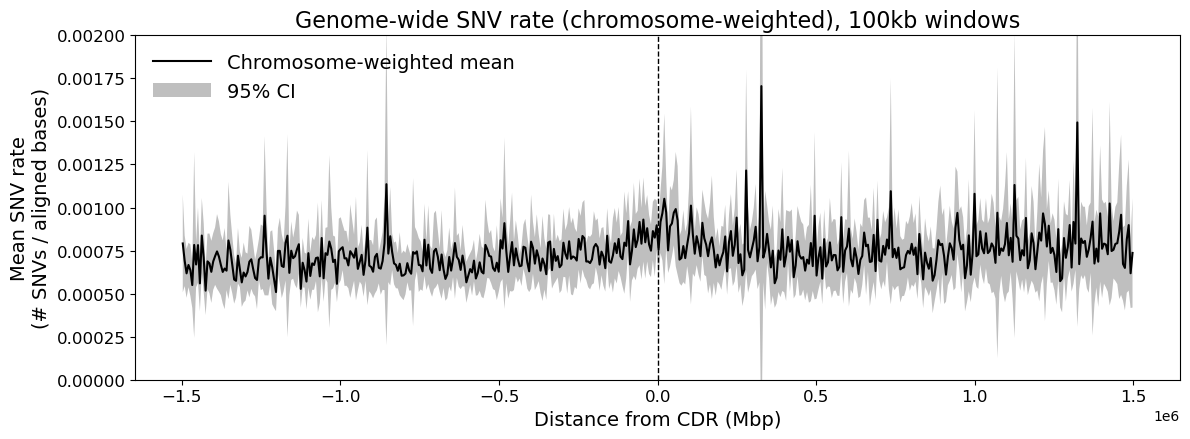

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05

# 1. Define bins and bin centers
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins  # 4000 bp

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

# ----------------------------
# 2. Filter and prepare dataframe
# ----------------------------
df = SNV_raw_100kb_df[
    SNV_raw_100kb_df["CDR_start"] != -1
].copy()

# ----------------------------
# Filter windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["window_end"] - df["window_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]

df = df[df["aligned_fraction"] >= 0.2].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Step 1: compute per-bin, per-chromosome stats
# ----------------------------
# Group by bin and chromosome
chrom_bin_stats = (
    df.groupby(["distance_bin", "chr"])
      .agg(
          chrom_mean=("SNV_rate_aln_bases", "mean"),
          n_windows=("SNV_rate_aln_bases", "count")
      )
      .reset_index()
)

# ----------------------------
# Step 2: filter chromosomes per-bin
# ----------------------------
# Only keep chromosomes with ≥50 windows in that bin
#chrom_bin_stats = chrom_bin_stats[chrom_bin_stats["n_windows"] >= 5]

# ----------------------------
# Step 3: chromosome-weighted mean per bin
# ----------------------------
agg = (
    chrom_bin_stats.groupby("distance_bin")
      .agg(
          mean_rate=("chrom_mean", "mean"),
          std_rate=("chrom_mean", "std"),
          n_chroms=("chrom_mean", "count")
      )
      .reset_index()
      .sort_values("distance_bin")
)

# ----------------------------
# Step 4: Confidence intervals (t distribution)
# ----------------------------
agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

# ----------------------------
# Step 5: Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 4.5))

# Mean line
ax.plot(
    agg["distance_bin"],
    agg["mean_rate"],
    color="black",
    linewidth=1.5,
    label="Chromosome-weighted mean"
)

# CI band (require ≥2 chromosomes)
valid = agg["n_chroms"] >= 2
ax.fill_between(
    agg.loc[valid, "distance_bin"],
    agg.loc[valid, "ci_low"],
    agg.loc[valid, "ci_high"],
    color="black",
    alpha=0.25,
    linewidth=0,
    label="95% CI"
)

ax.set_xlabel("Distance from CDR (Mbp)", fontsize=14)
ax.set_ylabel("Mean SNV rate\n(# SNVs / aligned bases)", fontsize=14)
ax.set_title("Genome-wide SNV rate (chromosome-weighted), 100kb windows", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_ylim(0, 0.002)
ax.legend(frameon=False, fontsize=14, handlelength=3)
ax.axvline(0, color="black", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()

## Debugging 

In [36]:
# ----------------------------
# 1. Filter windows with <20% aligned bases
# ----------------------------
df_filtered = df.copy()
df_filtered["window_size"] = df_filtered["window_end"] - df_filtered["window_start"]
df_filtered["aligned_fraction"] = df_filtered["aligned_bases"] / df_filtered["window_size"]

df_filtered = df_filtered[df_filtered["aligned_fraction"] >= 0.2].copy()

# Clean invalid SNV rates
df_filtered["SNV_rate_aln_bases"] = df_filtered["SNV_rate_aln_bases"].replace([np.inf, -np.inf], np.nan)

# ----------------------------
# 2. Assign numeric bin centers
# ----------------------------
df_filtered["distance_bin"] = pd.cut(
    df_filtered["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# 3. Select chr10 windows
# ----------------------------
chr10_windows = df_filtered[df_filtered["chr"] == "chr10"].copy()

# ----------------------------
# 4. Sort by SNV_rate and print entire rows
# ----------------------------
top_n = 20  # number of top windows to show
chr10_windows = chr10_windows.sort_values("SNV_rate_aln_bases", ascending=False).head(top_n)

print(f"Top {top_n} chr10 windows (after filtering <20% aligned bases):\n")
print(chr10_windows.to_string(index=False))



Top 20 chr10 windows (after filtering <20% aligned bases):

                     contig  window_start  window_end  SNV_counts  SNV_rate                  CDR_contig  CDR_start  CDR_end CDR_status  CDR_distance  aligned_bases   sample1   sample2   chr  both_pairs_CDR  SNV_rate_aln_bases  window_size  aligned_fraction  distance_bin
HG02965#2#JBHDWR010000005.1      41863000    41869245         241  0.038591 HG02965#2#JBHDWR010000005.1   41725566 41767342        CDR        -95659           1594 HG02965.2 HG03486.2 chr10            True            0.151192         6245          0.255244      -93000.0
       NA18570#1#CM087663.1      41411688    41411803          17  0.147826        NA18570#1#CM087663.1   40119072 40196790        CDR      -1214899            115 HG02071.1 NA18570.1 chr10            True            0.147826          115          1.000000    -1215000.0
HG00408#1#JBHDVK010000060.1      40132677    40142677         318  0.031800 HG00408#1#JBHDVK010000060.1   42160257 42170135    

## Per bin chrom weighted outlier

In [27]:
import numpy as np
import pandas as pd

# ----------------------------
# 1. Drop windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["window_end"] - df["window_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]

df = df[df["aligned_fraction"] >= 0.2].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace([np.inf, -np.inf], np.nan)

# ----------------------------
# 2. Assign numeric bin centers
# ----------------------------
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# 3. Per-chromosome stats per bin
# ----------------------------
chrom_bin_stats = (
    df.groupby(["distance_bin", "chr"])
      .agg(
          chrom_mean=("SNV_rate_aln_bases", "mean"),
          n_windows=("SNV_rate_aln_bases", "count")
      )
      .reset_index()
)

# ----------------------------
# 4. Filter chromosomes per bin (≥50 windows)
# ----------------------------
chrom_bin_stats = chrom_bin_stats[chrom_bin_stats["n_windows"] >= 50]

# ----------------------------
# 5. Chromosome-weighted mean per bin
# ----------------------------
agg = (
    chrom_bin_stats.groupby("distance_bin")
      .agg(
          mean_rate=("chrom_mean", "mean"),
          std_rate=("chrom_mean", "std"),
          n_chroms=("chrom_mean", "count")
      )
      .reset_index()
      .sort_values("distance_bin")
)

# ----------------------------
# 6. Identify the bin with the highest mean (within ±1 Mb)
# ----------------------------
within_1mb = agg[np.abs(agg["distance_bin"]) < 1_500_000]

max_idx = within_1mb["mean_rate"].idxmax()
max_bin_row = within_1mb.loc[max_idx]

max_bin = max_bin_row["distance_bin"]
max_rate = max_bin_row["mean_rate"]

print(f"Max-rate bin center (<1 Mb): {max_bin}")
print(f"Chromosome-weighted mean rate: {max_rate}")
print(f"Number of chromosomes contributing: {int(max_bin_row['n_chroms'])}")

# ----------------------------
# 7. Per-chromosome stats for that bin
# ----------------------------
per_chrom = (
    chrom_bin_stats[
        np.isclose(
            chrom_bin_stats["distance_bin"].values,
            max_bin,
            rtol=0,
            atol=1e-9
        )
    ]
    .sort_values("chrom_mean", ascending=False)
)

print("\nPer-chromosome stats for this bin:")
print(
    per_chrom[["chr", "chrom_mean", "n_windows"]].to_string(index=False)
)

# ----------------------------
# Optional sanity check
# ----------------------------
print("\nSanity check:")
print("Expected chromosomes:", int(max_bin_row["n_chroms"]))
print("Recovered chromosomes:", per_chrom.shape[0])


Max-rate bin center (<1 Mb): 1215000.0
Chromosome-weighted mean rate: 0.001736419498093976
Number of chromosomes contributing: 10

Per-chromosome stats for this bin:
  chr  chrom_mean  n_windows
chr12    0.009653         99
 chrX    0.001159        182
chr19    0.001138        126
chr11    0.001037        373
chr10    0.000950         74
 chr2    0.000916        344
 chr1    0.000874         96
 chr5    0.000578         62
chr20    0.000574         64
 chr8    0.000484        199

Sanity check:
Expected chromosomes: 10
Recovered chromosomes: 10


## Per chrom weighted - outlier peaks 

In [17]:
import numpy as np
import pandas as pd

# ----------------------------
# Filter chromosomes
# ----------------------------
df = df[df["chr"].isin(valid_chroms)].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace(
    [np.inf, -np.inf], np.nan
)

# ----------------------------
# Assign numeric bin centers
# ----------------------------
df["distance_bin"] = (
    pd.cut(
        df["CDR_distance"],
        bins=bins,
        labels=bin_centers,
        include_lowest=True
    )
    .astype(float)
)

# ----------------------------
# Step 1: per-chromosome stats per bin
# ----------------------------
chrom_bin_means = (
    df.groupby(["distance_bin", "chr"])
      .agg(
          chrom_mean=("SNV_rate_aln_bases", "mean"),
          n_windows=("SNV_rate_aln_bases", "count")
      )
      .reset_index()
)

# ----------------------------
# Step 2: chromosome-weighted mean per bin
# ----------------------------
agg = (
    chrom_bin_means
    .groupby("distance_bin")
    .agg(
        mean_rate=("chrom_mean", "mean"),
        std_rate=("chrom_mean", "std"),
        n_chroms=("chrom_mean", "count")
    )
    .reset_index()
    .sort_values("distance_bin")
)

# ----------------------------
# Identify the bin with the highest rate
# ----------------------------
# restrict to bins within 1 Mb of CDR
within_1mb = agg[np.abs(agg["distance_bin"]) < 1_000_000]

max_idx = within_1mb["mean_rate"].idxmax()
max_bin_row = within_1mb.loc[max_idx]

max_bin = max_bin_row["distance_bin"]
max_rate = max_bin_row["mean_rate"]

print(f"Max-rate bin center (<1 Mb): {max_bin}")
print(f"Chromosome-weighted mean rate: {max_rate}")
print(f"Number of chromosomes contributing: {int(max_bin_row['n_chroms'])}")

# ----------------------------
# Per-chromosome stats for that bin (float-safe)
# ----------------------------
per_chrom = (
    chrom_bin_means[
        np.isclose(
            chrom_bin_means["distance_bin"].values,
            max_bin,
            rtol=0,
            atol=1e-9
        )
    ]
    .sort_values("chrom_mean", ascending=False)
)

print("\nPer-chromosome stats for this bin:")
print(
    per_chrom[["chr", "chrom_mean", "n_windows"]]
    .to_string(index=False)
)

# ----------------------------
# Optional sanity check
# ----------------------------
print("\nSanity check:")
print("Expected chromosomes:", int(max_bin_row["n_chroms"]))
print("Recovered chromosomes:", per_chrom.shape[0])



Max-rate bin center (<1 Mb): 249000.0
Chromosome-weighted mean rate: 0.0030897112167920454
Number of chromosomes contributing: 20

Per-chromosome stats for this bin:
  chr  chrom_mean  n_windows
chr17    0.045979         22
chr10    0.001930         82
 chr1    0.001357        224
 chr2    0.001257        499
chr12    0.001210        161
chr19    0.001148        221
 chr9    0.001139        156
chr11    0.001105        432
 chr5    0.000774        141
chr15    0.000766         47
chr14    0.000756         79
 chrX    0.000630        151
 chr7    0.000615         49
chr22    0.000605        101
 chr8    0.000524        267
 chr6    0.000507         24
chr20    0.000454        174
chr16    0.000450         43
 chr3    0.000334         37
chr21    0.000252         10

Sanity check:
Expected chromosomes: 20
Recovered chromosomes: 20


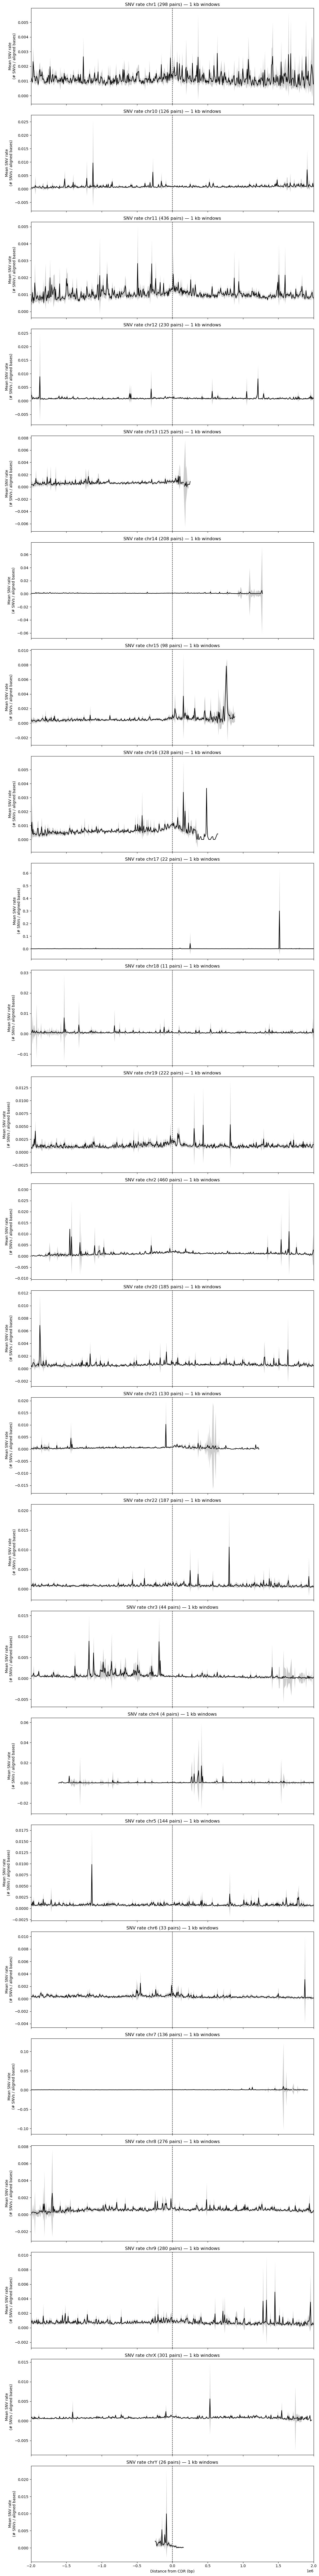

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# ----------------------------
# Parameters
# ----------------------------
alpha = 0.05
window_range = 2_000_000
n_bins = 500

# ----------------------------
# Filter for valid CDR positions
# ----------------------------
df = SNV_raw_10kb_df[
    SNV_raw_10kb_df["CDR_start"] != -1
].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df["SNV_rate_aln_bases"].replace(
    [np.inf, -np.inf], np.nan
)

# ----------------------------
# Define signed-distance bins
# ----------------------------
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(
    -window_range + bin_width / 2,
    window_range,
    bin_width
)

bins = np.concatenate([
    bin_centers - bin_width / 2,
    [bin_centers[-1] + bin_width / 2]
])

df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)

# ----------------------------
# Chromosomes
# ----------------------------
chromosomes = sorted(df["chr"].unique())

pair_counts = (
    df[["chr", "sample1", "sample2"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
    .to_dict()
)

# ----------------------------
# Plot
# ----------------------------
fig, axes = plt.subplots(
    len(chromosomes), 1,
    figsize=(12, 4 * len(chromosomes)),
    sharex=True
)

if len(chromosomes) == 1:
    axes = [axes]

for ax, chrom in zip(axes, chromosomes):
    chrom_df = df[df["chr"] == chrom]

    # ---- aggregate per bin ----
    agg = (
        chrom_df
        .groupby("distance_bin")
        .agg(
            mean_rate=("SNV_rate_aln_bases", "mean"),
            std_rate=("SNV_rate_aln_bases", "std"),
            n=("SNV_rate_aln_bases", "count")
        )
        .reset_index()
        .sort_values("distance_bin")
    )

    # ---- CI computation ----
    agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n"] - 1)
    agg["se"] = agg["std_rate"] / np.sqrt(agg["n"])
    agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
    agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

    # ---- mean line ----
    ax.plot(
        agg["distance_bin"],
        agg["mean_rate"],
        color="black",
        linewidth=1.5
    )

    # ---- CI band (n ≥ 2) ----
    valid = agg["n"] >= 2
    ax.fill_between(
        agg.loc[valid, "distance_bin"],
        agg.loc[valid, "ci_low"],
        agg.loc[valid, "ci_high"],
        color="grey",
        alpha=0.4,
        linewidth=0
    )

    # ---- formatting ----
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlim(-2_000_000, 2_000_000)
    ax.set_ylabel("Mean SNV rate\n(# SNVs / aligned bases)")

    n_pairs = pair_counts.get(chrom, 0)
    ax.set_title(f"SNV rate {chrom} ({n_pairs} pairs) — 10 kb windows")

axes[-1].set_xlabel("Distance from CDR (bp)")

plt.tight_layout()
plt.show()